In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sweetviz import viz_elements, get_roads
import svg
from IPython.display import SVG, display

def show(x):
    display(SVG(str(x)))

OFFSET_X = 12 # 10
OFFSET_Y = 0 # -1.2
w = 350 # 420 # -100
h = 350 # 420 # -100

In [ ]:
from dataset import PlanTDataset

import yaml
# Read YAML file
with open("config/config.yaml", 'r') as stream:
    cfg = yaml.safe_load(stream)

with open("config/model/PlanT.yaml", 'r') as stream:
    plnt = yaml.safe_load(stream)

plnt["training"]["input_ego"] = False
plnt["training"]["only_affects"] = True
plnt["training"]["augment"] = False
plnt["training"]["augment_parked"] = False

plnt["training"]["filter_routes"] = False


cfg["model"] = plnt

cfg["visualize"] = False

cfg["trainset_size"] = 1

class DictAsMember(dict):
    def __getattr__(self, name):
        value = self[name]
        if isinstance(value, dict):
            value = DictAsMember(value)
        return value

cfg = DictAsMember(cfg)

In [3]:
import torch
from dataset import generate_batch
from util.viz_batch import viz_batch
from lit_module import LitHFLM

/home/simon/miniconda3/envs/plant_2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
net = LitHFLM.load_from_checkpoint("/home/simon/PlanT_2_cleanup/PlanT/checkpoints/epoch=029_fourthfinal_both_1.ckpt", map_location="cpu") # "/home/simon/PlanT_2_cleanup/checkpoints/MLC/epoch=029_v6_mixds_1.ckpt"
net.eval();

In [5]:
def test_sample(data, town, save_path=None, route=False, path=False, wps=False):
    batch = generate_batch([data])
    batch["y_objs"] = None
    batch["pred_path"] = [[]] # batch["route"].numpy()

    _, _, (pred_path, pred_wp, _), _ = net(batch)

    batch["pred_path"] = pred_path.detach().numpy()
    batch["waypoints"] = pred_wp.detach().numpy()

    canvas = svg.SVG(
        width=w,
        height=h,
        elements=[]
    )

    viz = svg.G(elements=[], transform=[svg.Translate((w-1280)/2 - 10*OFFSET_Y, (h-1280)/2 + 10*OFFSET_X)])

    viz.elements.append(get_roads(*data["ego_pos"], -np.rad2deg(data["ego_rot"]), town))

    route = data["route_original"] if route else []
    path = pred_path[0].detach().numpy() if path else []
    wps = pred_wp[0].detach().numpy() if wps else []

    viz.elements += viz_elements(data["input"], route, path, wps)

    canvas.elements.append(viz)

    if save_path:
        with open(save_path, "w") as f:
            f.write(str(canvas))

    show(canvas)

    # Normal viz
    batch["pred_path"] = pred_path.detach().numpy()
    batch["waypoints"] = pred_wp.detach().numpy()
    viz = viz_batch(batch, 0, pix_per_m=7)
    fig = plt.gcf()
    fig.set_size_inches(7.5, 7.5)
    plt.imshow(cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))

In [6]:
# Rotations around origin
from scipy.ndimage import rotate

def rotate_box(box, theta):
    x = box[1]
    y = box[2]

    theta_rad = np.deg2rad(theta)

    cos_theta = np.cos(theta_rad)
    sin_theta = np.sin(theta_rad)

    x_rot = x * cos_theta - y * sin_theta
    y_rot = x * sin_theta + y * cos_theta

    return [box[0], x_rot, y_rot, box[3]+theta,*box[4:]]

def rotate_wps(wps, theta):
    theta_rad = np.deg2rad(theta) * -1
    rot_matrix = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad)]
    ])

    # Rotate
    rotated_wps = wps @ rot_matrix

    return rotated_wps

In [7]:
ds = PlanTDataset(f"/home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/DynamicObjectCrossing", cfg)

Loading 33464 samples
Total amount of routes: 271
Skipped routes: 0
Trainable routes: 271


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


/home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/DynamicObjectCrossing/Town13_Rep0_1742_0_route0_07_24_18_57_07/bev_no_car_semantics/0075.png
0


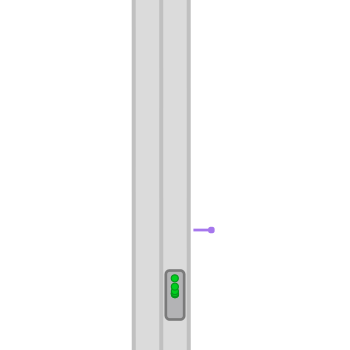

1


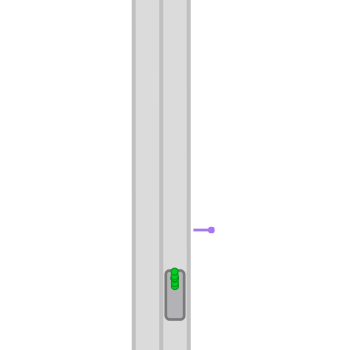

3


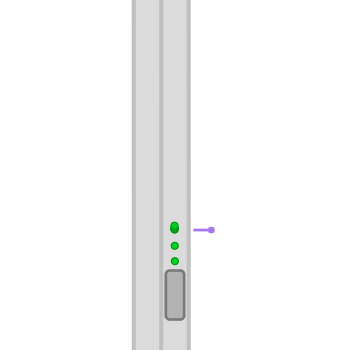

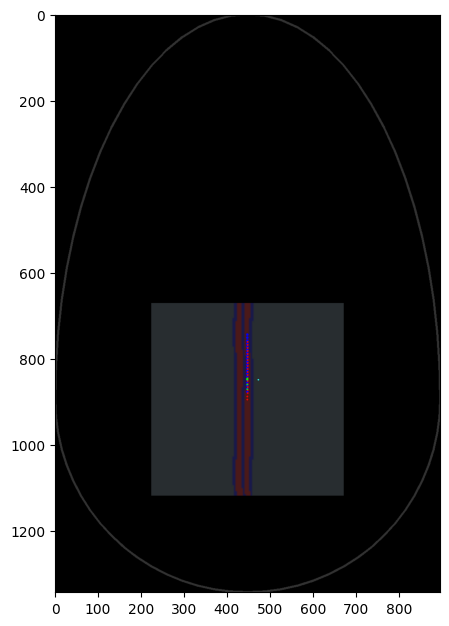

In [8]:
# TODO das kann man noch changen, ist noch net im paper
idx = 1136
print(ds.BEV[idx].decode())
for l in [0,1,3]:
    data = ds[idx]
    town = ds.BEV[idx].decode().split("/")[-3].split("_")[0]

    data["speed_limit"] = l

    data["input"] = [x for x in data["input"] if x[0]==2]

    for i in range(len(data["input"])):
        data["input"][i][1] -= 10
        data["input"][i][2] += 1.5
        data["input"][i][3] = 270

    print(data["speed_limit"])

    test_sample(data, town, None, wps=True)

## Construction Permutations

In [9]:
ds = PlanTDataset("/home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/ConstructionObstacleTwoWays", cfg)

Loading 12059 samples
Total amount of routes: 99
Skipped routes: 0
Trainable routes: 99


/home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/ConstructionObstacleTwoWays/Town13_Rep0_1763_1_route0_07_24_23_50_50/bev_no_car_semantics/0133.png


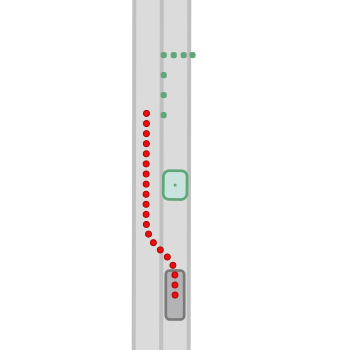

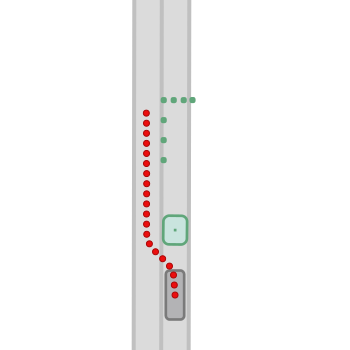

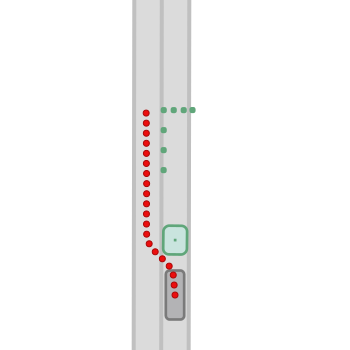

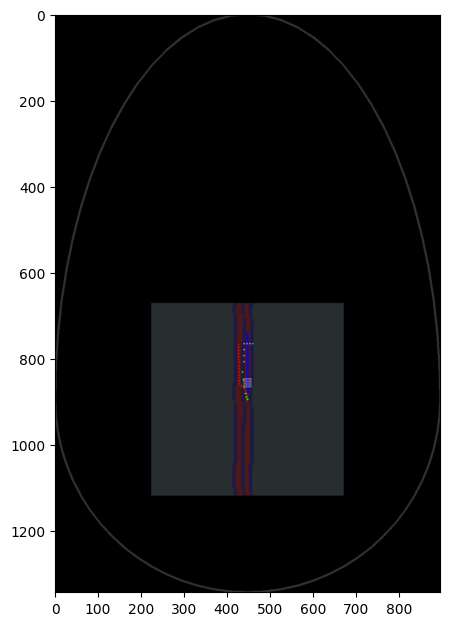

In [10]:
idx = 894
print(ds.BEV[idx].decode())
town = ds.BEV[idx].decode().split("/")[-3].split("_")[0]

for t in [-2, 2.5, 3.5]:
    data = ds[idx]
    data["input"] = [x for x in data["input"] if x[0] != 1]

    for i in range(len(data["input"])):
        data["input"][i][1] -= t

    test_sample(data, town, None, path=True) #f"/home/simon/PlanT_2_cleanup/Paper_viz/Construction_Distance_{str(t).replace('.','_')}.svg")


/home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/ConstructionObstacleTwoWays/Town13_Rep0_1763_1_route0_07_24_23_50_50/bev_no_car_semantics/0133.png


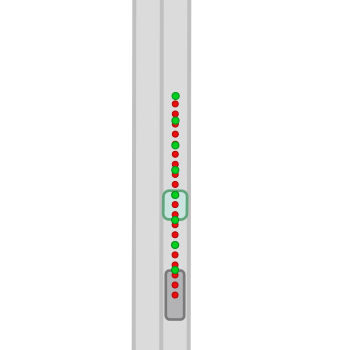

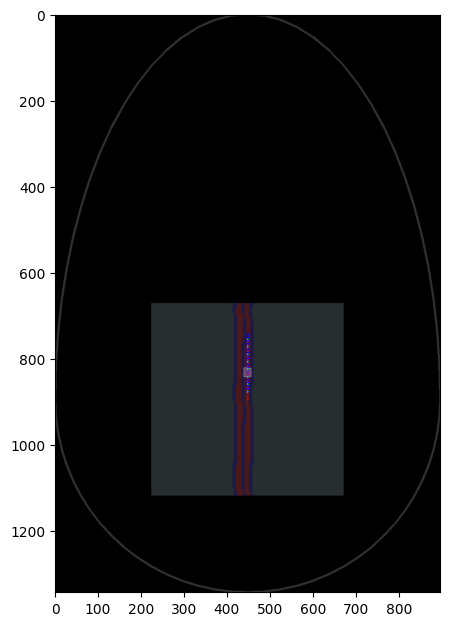

In [11]:
idx = 894
print(ds.BEV[idx].decode())
town = ds.BEV[idx].decode().split("/")[-3].split("_")[0]

data = ds[idx]
data["input"] = [x for x in data["input"] if x[0] == 3 and x[-1] > 0.4]

test_sample(data, town, None, path=True, wps=True) #f"/home/simon/PlanT_2_cleanup/Paper_viz/Construction_nocones_{str(t).replace('.','_')}.svg")


/home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/ConstructionObstacleTwoWays/Town13_Rep0_1763_1_route0_07_24_23_50_50/bev_no_car_semantics/0133.png


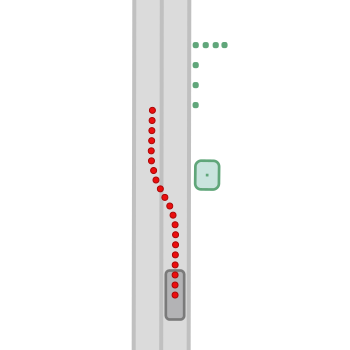

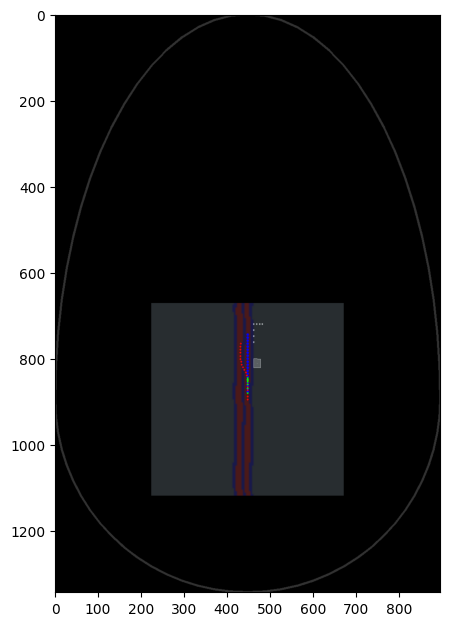

In [12]:
idx = 894
print(ds.BEV[idx].decode())
town = ds.BEV[idx].decode().split("/")[-3].split("_")[0]

data = ds[idx]
data["input"] = [x for x in data["input"] if x[0] != 1]

x = -3
t = -3.2

for i in range(len(data["input"])):
    data["input"][i][1] -= x
    data["input"][i][2] -= t

test_sample(data, town, None, path=True) # f"/home/simon/PlanT_2_cleanup/Paper_viz/Construction_Right_gut_{str(t).replace('.','_')}.svg")


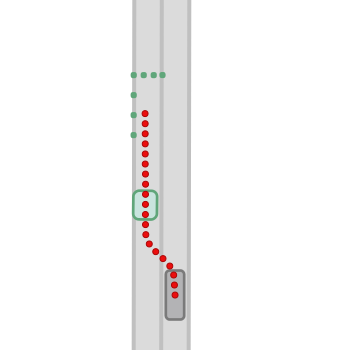

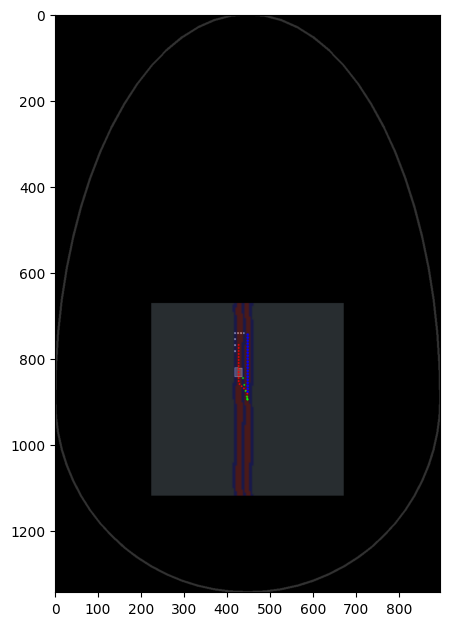

In [13]:
idx = 894
town = ds.BEV[idx].decode().split("/")[-3].split("_")[0]

data = ds[idx]
data["input"] = [x for x in data["input"] if x[0] != 1]

t = 3

for i in range(len(data["input"])):
    data["input"][i][2] -= t

test_sample(data, town, None, path=True) #f"/home/simon/PlanT_2_cleanup/Paper_viz/Construction_Right_gut_{str(t).replace('.','_')}.svg")


In [14]:
ds = PlanTDataset("/home/simon/PlanT_2_cleanup/PlanT_2_dataset/data", cfg)

Loading 645259 samples
Total amount of routes: 5562
Skipped routes: 0
Trainable routes: 5562


/home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/ConstructionObstacleTwoWays/Town13_Rep0_1766_0_route0_07_24_19_04_51/bev_no_car_semantics/0078.png
Speed limit 0
0


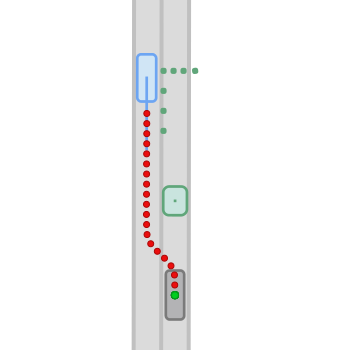

15


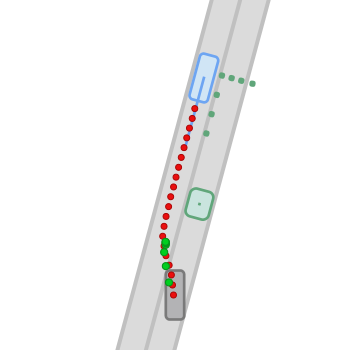

30


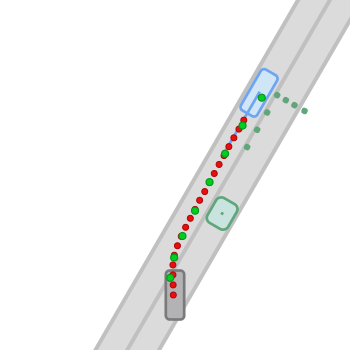

45


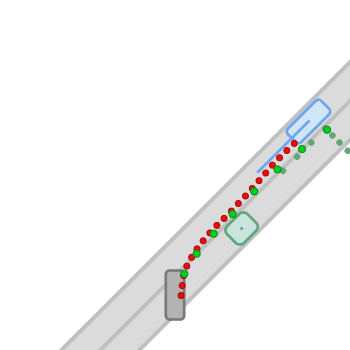

/home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/AccidentTwoWays/Town12_Rep0_1152_0_route0_07_24_14_15_04/bev_no_car_semantics/0089.png
Speed limit 0
0


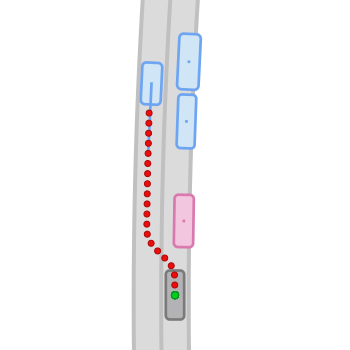

15


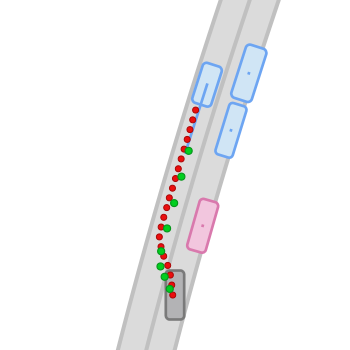

30


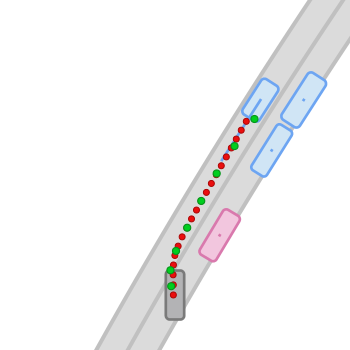

45


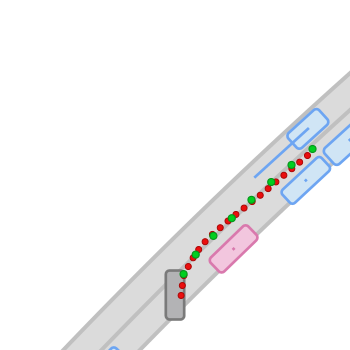

/home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/ParkedObstacleTwoWays/Town13_Rep0_1522_0_route0_07_24_23_46_40/bev_no_car_semantics/0075.png
Speed limit 0
0


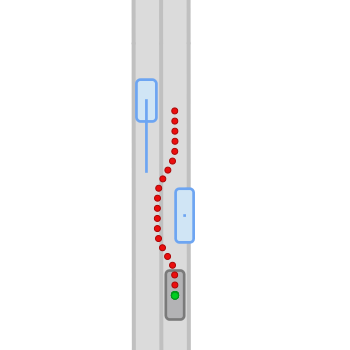

15


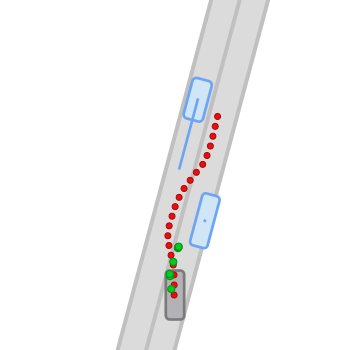

30


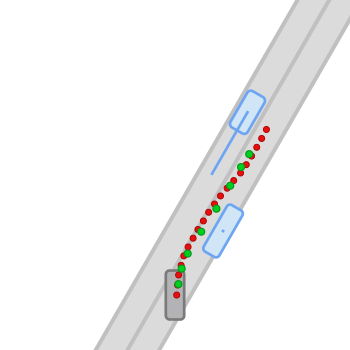

45


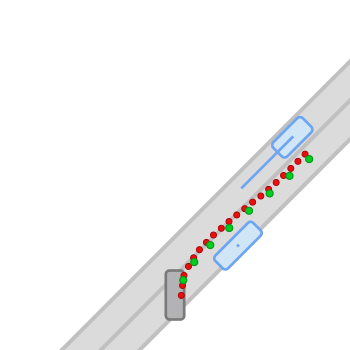

/home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/VehicleOpensDoorTwoWays/Town12_Rep0_3784_1_route0_07_25_05_32_46/bev_no_car_semantics/0051.png
Speed limit 0
0


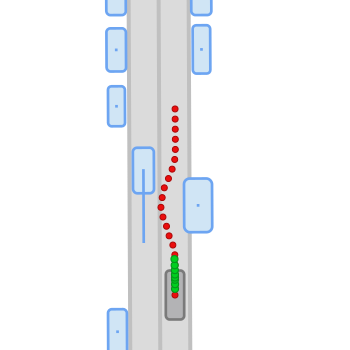

15


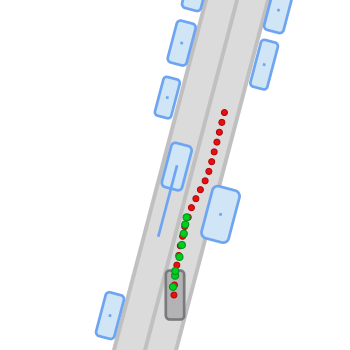

30


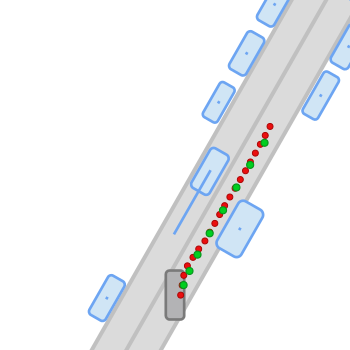

45


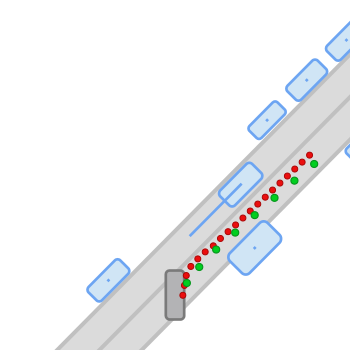

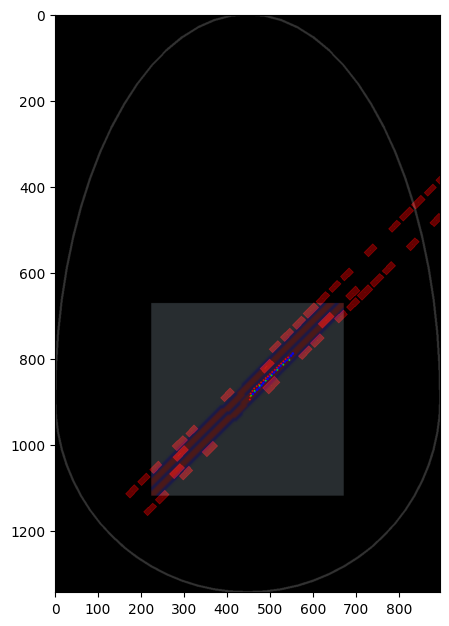

In [15]:
### Rotate construction site

results = {}

for i, scenario in [[75920 , "ConstructionObstacleTwoWays"], [223029, "AccidentTwoWays"], [585693, "ParkedObstacleTwoWays"], [319218, "VehicleOpensDoorTwoWays"]]:

    # ds = PlanTDataset(f"/home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/", cfg) # {scenario}
    allspeeds = []
    allrots = []

    print(ds.BEV[i].decode())
    print("Speed limit", ds[i]["speed_limit"])

    for r in range(0,46,1):
        data = ds[i]
        town = ds.BEV[i].decode().split("/")[-3].split("_")[0]

        data["input"] = [rotate_box(x, r) for x in data["input"]]
        data["route_original"] = rotate_wps(data["route_original"], r)
        data["BEV"] = rotate(data["BEV"], -r, order=1, axes=(2, 1), reshape=False, mode="reflect")

        batch = generate_batch([data])
        batch["y_objs"] = None
        batch["pred_path"] = [[]] # batch["route"].numpy()

        _, _, (pred_path, pred_wp, _), _ = net(batch)

        pred_wp = pred_wp[0].detach().numpy()

        allrots.append(r)
        allspeeds.append(np.linalg.norm(pred_wp[2]-pred_wp[3])*4)

        if r%15==0:
            print(r)
            data["ego_rot"] -= np.deg2rad(r)
            test_sample(data, town, None, path=True, wps=True)#f"/home/simon/PlanT_2_cleanup/Paper_viz/Rotations/{scenario}_Rotation_{r}.svg")
    
    results[scenario] = (allrots, allspeeds)

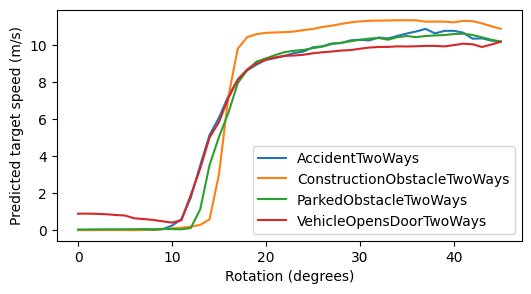

In [16]:
# plt.axvline(5, label = 'Maximum rotation augmentation')


######### abchecken ob hier die speed limits gleich sind bei den examples, ich denk nämlich nicht, dann wär es besser accidenttwoways anzupassen damit der plot schöner ist

fig = plt.gcf()
fig.set_size_inches(6, 3)

for scenario, (allrots, allspeeds) in sorted(results.items(), key=lambda l: l[0]):
    plt.plot(allrots, allspeeds, label = scenario)

plt.ylabel("Predicted target speed (m/s)")
plt.xlabel("Rotation (degrees)")

plt.legend()

0.0 12.837163511160462
0.46153846153846156 12.387443520866121
0.9230769230769231 11.938625651890803
1.3846153846153846 11.490815612143495
1.8461538461538463 11.044135996606293
2.307692307692308 10.598729730196334
2.769230769230769 10.15476436845873
3.230769230769231 9.712437509042152
3.6923076923076925 9.271983652818715


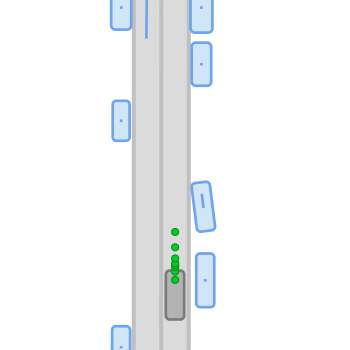

4.153846153846154 8.833682972134813
4.615384615384616 8.397872608535463
5.0769230769230775 7.9649613526466325
5.538461538461538 7.53544888192318
6.0 7.109951185342887


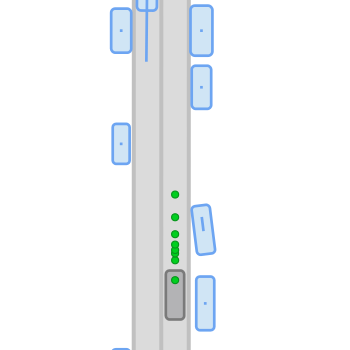

6.461538461538462 6.6892344380204465
6.923076923076923 6.274260464676079
7.384615384615385 5.86624811044968


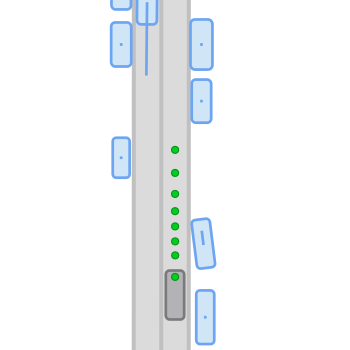

7.846153846153847 5.466756342756661
8.307692307692308 5.077796611892257
8.76923076923077 4.7019833533709345
9.230769230769232 4.342730935939832
9.692307692307693 4.004498971346965
10.153846153846155 3.693067497897586
10.615384615384617 3.415774960312044
11.076923076923077 3.1815601704070513
11.538461538461538 3.000527813452979
12.0 2.882714814831302


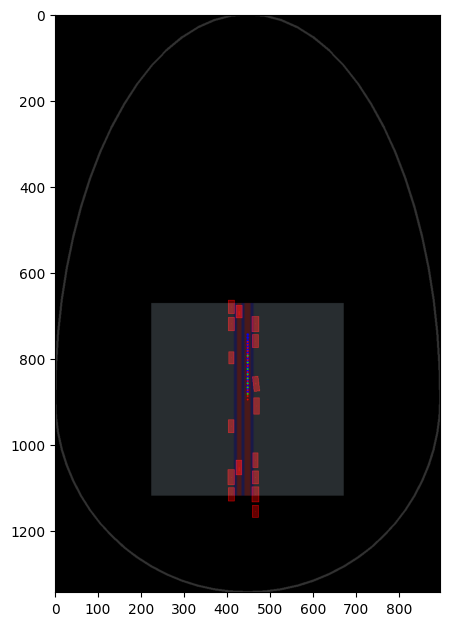

In [17]:
idx = 47412
town = ds.BEV[idx].decode().split("/")[-3].split("_")[0]

distances = []
speeds = []

for t in np.linspace(0, 12, 27): # [1.5, 7.5, 10.5, 11.5, 12.5]: # # [1.5, 7.5, 10.5]: # 
    data = ds[idx]
    data["input"] = [x for x in data["input"] if  x[0] != 6 and abs(x[2]) > 0.7 and np.linalg.norm(x[1:2]) < 40] # (x[4] < 0.1 or x[3]<-5) and

    for i in range(len(data["input"])):
        # if data["input"][i][3] < -2:
        #     # data["input"][i][2] -= 0.3
        #     data["input"][i][3] -= 5
        #     # data["input"][i][4] += 7

        data["input"][i][1] -= t
        if data["input"][i][0] == 7.0:
            data["input"][i][0] = 2.0

    scenario_car = [x for x in data["input"] if abs(x[3]+7.09)<0.1][0]
    scenario_dist = np.linalg.norm(scenario_car[1:3])
    print(t, scenario_dist)

    if t in [3.6923076923076925, 6.0, 7.384615384615385]:
        test_sample(data, town, None, wps=True) # f"/home/simon/PlanT_2_cleanup/Paper_viz/ParkingCutIn{str(t).replace('.','_')}.svg")

    batch = generate_batch([data])
    batch["y_objs"] = None
    batch["pred_path"] = [[]] # batch["route"].numpy()

    _, _, (pred_path, pred_wp, _), _ = net(batch)

    pred_wp = pred_wp[0].detach().numpy()
    speeds.append(np.linalg.norm(pred_wp[2]-pred_wp[3])*4*3.6)

    distances.append(scenario_dist)


Text(0, 0.5, 'Predicted target speed (m/s)')

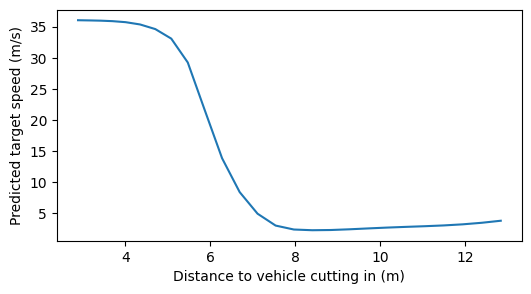

In [18]:
fig = plt.gcf()
fig.set_size_inches(6, 3)

plt.plot(distances, speeds)
plt.xlabel("Distance to vehicle cutting in (m)")
plt.ylabel("Predicted target speed (m/s)")

## Failures on validation routes

In [19]:
import svg
from sweetviz import get_roads, viz_elements, control_indicator, box2svg, waypoint
from IPython.display import SVG, display
import numpy as np
import json

def show(x):
    display(SVG(str(x)))

In [20]:
w = 420 # -100
h = 420 # -100
canvas = svg.SVG(
    width=w,
    height=h,
    elements=[]
)

In [21]:
DISTANCE = 32+3
# OFFSET_X = 5
# OFFSET_Y = -1.25

OFFSET_X = 0
OFFSET_Y = 0

town = "Town13"

In [22]:
def rotate_point(point, theta):
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    return rotation_matrix @ np.array(point)

In [23]:
ego_box = [0, 0, 0, 0, 0, 0.9183566570281982*2, 2.44619083404541*2]

In [24]:
records_1 = ['{"boxes": [[1.0, -14.873481750488281, -5.639025688171387, -166.253173828125, 29.6407470703125, 1.9941171407699585, 4.181210041046143], [3.0, 16.064159393310547, 6.490943431854248, 15.614801406860352, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 16.261821746826172, 5.672581672668457, 103.74263000488281, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 16.4993953704834, 4.701847553253174, 103.7450942993164, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 16.736968994140625, 3.731104612350464, 13.746370315551758, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 14.794458389282227, 3.2551803588867188, 13.745833396911621, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 12.851701736450195, 2.7792398929595947, 13.74553394317627, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 10.909475326538086, 2.3031692504882812, 13.745670318603516, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 3.858415126800537, 1.783359408378601, -75.85336303710938, 0.0, 2.8705859184265137, 2.373429536819458]], "ego_pos": [3138.561767578125, 4066.47216796875], "ego_rot": -0.22642512718704744, "waypoints": [[1.693411946296692, -0.5091347694396973], [3.9339652061462402, -0.9105634689331055], [6.600193023681641, -0.8948259949684143], [9.434425354003906, -0.3807597756385803], [12.775684356689453, 0.4889931082725525], [15.88271713256836, 1.5661535263061523], [19.08115577697754, 2.8780155181884766], [21.914608001708984, 4.27426815032959]], "route_original": [[2.229783058166504, 1.379212737083435], [3.2010393142700195, 1.616745948791504], [4.172500133514404, 1.8543262481689453], [5.143919467926025, 2.0919322967529297], [6.115128517150879, 2.329669952392578], [7.0865559577941895, 2.5672426223754883], [8.057811737060547, 2.8047759532928467], [9.029265403747559, 3.0423896312713623], [10.000645637512207, 3.2801668643951416], [10.971901893615723, 3.517699956893921], [11.94336223602295, 3.7552802562713623], [12.914789199829102, 3.9928529262542725], [13.886037826538086, 4.230419635772705], [14.857418060302734, 4.468196868896484], [15.82867431640625, 4.705729961395264], [16.800134658813477, 4.943310260772705], [17.771554946899414, 5.1809163093566895], [18.74276351928711, 5.418653964996338], [19.714223861694336, 5.656234264373779], [20.685651779174805, 5.8938069343566895]], "route": [[-0.009052997455000877, -0.12059403210878372], [0.9746237993240356, -0.3201500177383423], [1.973707675933838, -0.4090905785560608], [2.9488844871520996, -0.6113600134849548], [3.9076199531555176, -0.8280065655708313], [4.894148349761963, -0.9293968081474304], [5.896770000457764, -0.8544497489929199], [6.896668434143066, -0.7451522946357727], [7.889317989349365, -0.5677976012229919], [8.877035140991211, -0.34747493267059326], [9.863243103027344, -0.127041295170784], [10.848017692565918, 0.08447147905826569], [11.840251922607422, 0.2983701825141907], [12.821181297302246, 0.539737343788147], [13.80433177947998, 0.7656978368759155], [14.795881271362305, 0.9977037906646729], [15.783088684082031, 1.2393485307693481], [16.755996704101562, 1.5510878562927246], [17.678552627563477, 2.0018341541290283], [18.530128479003906, 2.580947160720825]], "control_history": [[-0.07123685685917205, 1.0, 0.0], [-0.07769995146967593, 1.0, 0.0], [-0.08531406671839742, 1.0, 0.0], [-0.09806418742567588, 1.0, 0.0], [-0.09036965844546542, 1.0, 0.0], [-0.07786262134824468, 1.0, 0.0], [-0.06400308273495182, 1.0, 0.0], [-0.05185603222687511, 1.0, 0.0], [-0.05548875356795074, 1.0, 0.0], [-0.046430325179100174, 1.0, 0.0], [-0.049540773545743336, 1.0, 0.0], [-0.036633504020157824, 1.0, 0.0], [-0.034512761647920547, 1.0, 0.0], [-0.05054002573675187, 1.0, 0.0], [-0.027681958030360165, 1.0, 0.0], [-0.05391558812453324, 1.0, 0.0], [-0.04725922925665689, 1.0, 0.0], [-0.035019655452474666, 1.0, 0.0], [-0.022527004946959615, 1.0, 0.0], [-0.10567470620263322, 1.0, 0.0], [-0.32090023192392697, 1.0, 0.0], [-0.6648256107825468, 1.0, 0.0], [-0.5803235685475735, 1.0, 0.0], [-0.5489361187231278, 1.0, 0.0], [-0.44607184570856906, 1.0, 0.0]], "frame": 146055, "ego_speed": 8.68}',
 '{"boxes": [[1.0, -17.372793197631836, -8.422395706176758, -157.75730895996094, 29.36209487915039, 1.9941171407699585, 4.181210041046143], [3.0, 13.354876518249512, 8.928648948669434, 24.1090030670166, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 13.672891616821289, 8.143054962158203, 112.23683166503906, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 14.05135726928711, 7.21737813949585, 112.23930358886719, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 14.429823875427246, 6.291699409484863, 22.240571975708008, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 12.578699111938477, 5.534701824188232, 22.240034103393555, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 10.72734260559082, 4.777622699737549, 22.239736557006836, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 8.876530647277832, 4.02049446105957, 22.239871978759766, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 2.2449586391448975, 2.7448947429656982, -49.147701263427734, 0.0, 2.8705859184265137, 2.373429536819458]], "ego_pos": [3139.9775390625, 4065.771240234375], "ego_rot": -0.3746774951603751, "waypoints": [[2.292506456375122, 0.21093851327896118], [4.932828903198242, 0.7105920314788818], [8.01396656036377, 1.590820074081421], [11.090900421142578, 2.7087340354919434], [14.254009246826172, 4.228507041931152], [17.062849044799805, 6.082938194274902], [19.655120849609375, 8.202381134033203], [21.89052391052246, 10.431900024414062]], "route_original": [[1.723327875137329, 2.3573920726776123], [2.6490392684936523, 2.735860586166382], [3.574579954147339, 3.11440372467041], [4.50014591217041, 3.4929356575012207], [5.425734519958496, 3.8713560104370117], [6.351341724395752, 4.249783515930176], [7.277005195617676, 4.628375053405762], [8.202552795410156, 5.006899833679199], [9.128159523010254, 5.385327339172363], [10.053871154785156, 5.763795852661133], [10.979459762573242, 6.142216205596924], [11.90501880645752, 6.520766735076904], [12.83056640625, 6.899291515350342], [13.756173133850098, 7.277719020843506], [14.681884765625, 7.656187534332275], [15.607425689697266, 8.034730911254883], [16.532991409301758, 8.413262367248535], [17.458703994750977, 8.791730880737305], [18.384292602539062, 9.170151710510254], [19.309850692749023, 9.548701286315918]], "route": [[-0.008428758010268211, -0.06405039131641388], [0.996464192867279, -0.06060890480875969], [2.0023701190948486, -0.032848767936229706], [2.998673439025879, 0.04222681373357773], [3.980724811553955, 0.2396203577518463], [4.961336135864258, 0.49543288350105286], [5.930630683898926, 0.7790552377700806], [6.907639980316162, 1.0287845134735107], [7.866060733795166, 1.3698915243148804], [8.817413330078125, 1.7189888954162598], [9.758756637573242, 2.1057491302490234], [10.691815376281738, 2.494530439376831], [11.643664360046387, 2.8604800701141357], [12.589221954345703, 3.242316484451294], [13.523594856262207, 3.643857955932617], [14.461233139038086, 4.042301177978516], [15.398184776306152, 4.430815696716309], [16.290952682495117, 4.931541919708252], [17.122716903686523, 5.5506672859191895], [17.80885124206543, 6.313611030578613]], "control_history": [[-0.07786262134824468, 1.0, 0.0], [-0.06400308273495182, 1.0, 0.0], [-0.05185603222687511, 1.0, 0.0], [-0.05548875356795074, 1.0, 0.0], [-0.046430325179100174, 1.0, 0.0], [-0.049540773545743336, 1.0, 0.0], [-0.036633504020157824, 1.0, 0.0], [-0.034512761647920547, 1.0, 0.0], [-0.05054002573675187, 1.0, 0.0], [-0.027681958030360165, 1.0, 0.0], [-0.05391558812453324, 1.0, 0.0], [-0.04725922925665689, 1.0, 0.0], [-0.035019655452474666, 1.0, 0.0], [-0.022527004946959615, 1.0, 0.0], [-0.10567470620263322, 1.0, 0.0], [-0.32090023192392697, 1.0, 0.0], [-0.6648256107825468, 1.0, 0.0], [-0.5803235685475735, 1.0, 0.0], [-0.5489361187231278, 1.0, 0.0], [-0.44607184570856906, 1.0, 0.0], [-0.26079330092227593, 1.0, 0.0], [-0.24222843780820263, 1.0, 0.0], [-0.17043376877019695, 1.0, 0.0], [-0.09582316073864935, 1.0, 0.0], [-0.007402035047272777, 1.0, 0.0]], "frame": 146060, "ego_speed": 6.77}',
 '{"boxes": [[1.0, -21.48048210144043, -8.33301067352295, -160.14794921875, 29.35165786743164, 1.9941171407699585, 4.181210041046143], [3.0, 11.837055206298828, 8.397555351257324, 21.718576431274414, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 12.121766090393066, 7.595021724700928, 109.84640502929688, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 12.46129035949707, 6.654458999633789, 109.848876953125, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 12.800816535949707, 5.713900089263916, 19.85014533996582, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 10.919764518737793, 5.035518646240234, 19.849607467651367, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 9.038477897644043, 4.3570380210876465, 19.84930992126465, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 7.157732963562012, 3.6784870624542236, 19.849445343017578, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 0.47712671756744385, 2.71661639213562, -51.05379104614258, 0.0, 2.8705859184265137, 2.373429536819458]], "ego_pos": [3141.74169921875, 4065.124267578125], "ego_rot": -0.33295638958481355, "waypoints": [[2.5144295692443848, 0.6055814623832703], [5.401548862457275, 1.194037914276123], [8.631677627563477, 2.0709919929504395], [11.79245662689209, 3.288710117340088], [14.889816284179688, 4.896811008453369], [17.51801872253418, 6.870855331420898], [19.892324447631836, 9.074368476867676], [22.092735290527344, 11.122356414794922]], "route_original": [[1.6345634460449219, 2.929511070251465], [2.575049877166748, 3.269139528274536], [3.5156631469726562, 3.6086411476135254], [4.456202507019043, 3.948117256164551], [5.396866798400879, 4.287724494934082], [6.337427139282227, 4.627378463745117], [7.277966499328613, 4.966854572296143], [8.218657493591309, 5.30638313293457], [9.159271240234375, 5.645884990692139], [10.099782943725586, 5.985439300537109], [11.040343284606934, 6.3250932693481445], [11.98088264465332, 6.66456937789917], [12.921574592590332, 7.004098415374756], [13.862159729003906, 7.3436784744262695], [14.80264663696289, 7.683306694030762], [15.743338584899902, 8.022835731506348], [16.683950424194336, 8.362337112426758], [17.62446403503418, 8.701891899108887], [18.565101623535156, 9.041572570800781], [19.505714416503906, 9.381073951721191]], "route": [[-0.0179526936262846, 0.18126632273197174], [0.9856020212173462, 0.2304469794034958], [1.990709662437439, 0.28761011362075806], [2.985833168029785, 0.41114282608032227], [3.964564800262451, 0.6495047807693481], [4.945602893829346, 0.9006654620170593], [5.920678615570068, 1.165426254272461], [6.9044904708862305, 1.3937658071517944], [7.872326374053955, 1.7077982425689697], [8.83446979522705, 2.021864652633667], [9.785555839538574, 2.379568099975586], [10.732397079467773, 2.734726667404175], [11.692707061767578, 3.066549777984619], [12.639881134033203, 3.448331117630005], [13.566770553588867, 3.8573694229125977], [14.496362686157227, 4.262444496154785], [15.384261131286621, 4.748870372772217], [16.18842887878418, 5.3933281898498535], [16.89015769958496, 6.158024311065674], [17.46143913269043, 7.012943267822266]], "control_history": [[-0.049540773545743336, 1.0, 0.0], [-0.036633504020157824, 1.0, 0.0], [-0.034512761647920547, 1.0, 0.0], [-0.05054002573675187, 1.0, 0.0], [-0.027681958030360165, 1.0, 0.0], [-0.05391558812453324, 1.0, 0.0], [-0.04725922925665689, 1.0, 0.0], [-0.035019655452474666, 1.0, 0.0], [-0.022527004946959615, 1.0, 0.0], [-0.10567470620263322, 1.0, 0.0], [-0.32090023192392697, 1.0, 0.0], [-0.6648256107825468, 1.0, 0.0], [-0.5803235685475735, 1.0, 0.0], [-0.5489361187231278, 1.0, 0.0], [-0.44607184570856906, 1.0, 0.0], [-0.26079330092227593, 1.0, 0.0], [-0.24222843780820263, 1.0, 0.0], [-0.17043376877019695, 1.0, 0.0], [-0.09582316073864935, 1.0, 0.0], [-0.007402035047272777, 1.0, 0.0], [0.09340694714629338, 1.0, 0.0], [0.1619465595168933, 1.0, 0.0], [0.21500545197382992, 1.0, 0.0], [0.272678577612995, 1.0, 0.0], [0.3175627791333923, 1.0, 0.0]], "frame": 146065, "ego_speed": 8.08}',
 '{"boxes": [[1.0, -26.899660110473633, -4.4435200691223145, -170.94869995117188, 29.70539665222168, 1.9941171407699585, 4.181210041046143], [3.0, 11.022697448730469, 6.070208549499512, 10.918319702148438, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 11.152764320373535, 5.2263054847717285, 99.046142578125, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 11.310005187988281, 4.239140033721924, 99.04861450195312, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 11.467247009277344, 3.2519824504852295, 9.049888610839844, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 9.492256164550781, 2.938460111618042, 9.049351692199707, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 7.517019748687744, 2.624868631362915, 9.049052238464355, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 5.542301654815674, 2.311107873916626, 9.049188613891602, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -1.2057322263717651, 2.630129098892212, -61.933204650878906, 0.0, 2.8705859184265137, 2.373429536819458]], "ego_pos": [3143.891845703125, 4064.771240234375], "ego_rot": -0.1444562236454825, "waypoints": [[2.887583017349243, 0.2708408534526825], [6.0252790451049805, 0.5336250066757202], [9.416799545288086, 0.9435017704963684], [12.700908660888672, 1.9242557287216187], [15.806743621826172, 3.3748085498809814], [18.499385833740234, 5.0092854499816895], [21.313236236572266, 6.2609333992004395], [23.94175148010254, 7.017608165740967]], "route_original": [[2.0497660636901855, 2.941481590270996], [3.0372822284698486, 3.0987043380737305], [4.024918079376221, 3.2560527324676514], [5.012443542480469, 3.413414716720581], [5.999959468841553, 3.5706372261047363], [6.987610816955566, 3.727879524230957], [7.975155830383301, 3.885106325149536], [8.962656021118164, 4.042435169219971], [9.95018196105957, 4.1997971534729], [10.937697410583496, 4.357019901275635], [11.925349235534668, 4.514261722564697], [12.91287899017334, 4.671595096588135], [13.900375366210938, 4.828952789306641], [14.888026237487793, 4.986195087432861], [15.875571250915527, 5.143421649932861], [16.86307144165039, 5.300750732421875], [17.850704193115234, 5.458127975463867], [18.83824920654297, 5.615355014801025], [19.82576560974121, 5.772577285766602], [20.813310623168945, 5.92980432510376]], "route": [[-0.008552173152565956, 0.07454631477594376], [0.9974697828292847, 0.10211750119924545], [2.002427339553833, 0.11743347346782684], [3.006683349609375, 0.17236244678497314], [4.0083327293396, 0.2645203769207001], [5.012099266052246, 0.3576946258544922], [6.013976573944092, 0.46825146675109863], [7.020204544067383, 0.5409411191940308], [8.027088165283203, 0.658210813999176], [9.027276992797852, 0.7922481298446655], [10.027613639831543, 0.9384227991104126], [11.023244857788086, 1.0754125118255615], [12.017928123474121, 1.2248263359069824], [12.996369361877441, 1.4849886894226074], [13.9135103225708, 1.866790533065796], [14.764445304870605, 2.40157151222229], [15.543671607971191, 3.066969633102417], [16.273681640625, 3.7979543209075928], [16.956321716308594, 4.575974464416504], [17.631376266479492, 5.327110290527344]], "control_history": [[-0.05391558812453324, 1.0, 0.0], [-0.04725922925665689, 1.0, 0.0], [-0.035019655452474666, 1.0, 0.0], [-0.022527004946959615, 1.0, 0.0], [-0.10567470620263322, 1.0, 0.0], [-0.32090023192392697, 1.0, 0.0], [-0.6648256107825468, 1.0, 0.0], [-0.5803235685475735, 1.0, 0.0], [-0.5489361187231278, 1.0, 0.0], [-0.44607184570856906, 1.0, 0.0], [-0.26079330092227593, 1.0, 0.0], [-0.24222843780820263, 1.0, 0.0], [-0.17043376877019695, 1.0, 0.0], [-0.09582316073864935, 1.0, 0.0], [-0.007402035047272777, 1.0, 0.0], [0.09340694714629338, 1.0, 0.0], [0.1619465595168933, 1.0, 0.0], [0.21500545197382992, 1.0, 0.0], [0.272678577612995, 1.0, 0.0], [0.3175627791333923, 1.0, 0.0], [0.2902014450349403, 1.0, 0.0], [0.2833538274401739, 1.0, 0.0], [0.21280206724115996, 1.0, 0.0], [0.1802596029072778, 1.0, 0.0], [0.14816081536872305, 1.0, 0.0]], "frame": 146070, "ego_speed": 9.38}',
 '{"boxes": [[1.0, -31.783187866210938, -1.3214863538742065, -177.62808227539062, 29.12628746032715, 1.9941171407699585, 4.181210041046143], [3.0, 9.122885704040527, 4.799753189086914, 4.240087509155273, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 9.154557228088379, 3.9476499557495117, 92.36791229248047, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 9.19587516784668, 2.9486806392669678, 92.3703842163086, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 9.23719310760498, 1.9497169256210327, 2.3716564178466797, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 7.239029407501221, 1.8676598072052002, 2.371119499206543, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 5.2406182289123535, 1.7855713367462158, 2.3708205223083496, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 3.2427024841308594, 1.7032538652420044, 2.3709561824798584, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -3.4379098415374756, 2.804730176925659, -69.15764617919922, 0.0, 2.8705859184265137, 2.373429536819458]], "ego_pos": [3146.420654296875, 4064.650146484375], "ego_rot": -0.027899221577916578, "waypoints": [[3.275904417037964, 0.02047577127814293], [6.652065753936768, 0.10836924612522125], [10.106306076049805, 0.43063586950302124], [13.267333030700684, 1.522320032119751], [16.35384750366211, 2.746757745742798], [19.205665588378906, 3.289560079574585], [22.180278778076172, 3.4252500534057617], [24.741973876953125, 3.485654354095459]], "route_original": [[2.3446779251098633, 2.837174415588379], [3.343684434890747, 2.8785006999969482], [4.3429059982299805, 2.91981840133667], [5.342142105102539, 2.96113657951355], [6.34114933013916, 3.002448320388794], [7.340364456176758, 3.0439953804016113], [8.339370727539062, 3.0853216648101807], [9.338592529296875, 3.1266393661499023], [10.337828636169434, 3.1679575443267822], [11.33682918548584, 3.209498643875122], [12.336050033569336, 3.250830888748169], [13.335287094116211, 3.292149066925049], [14.334293365478516, 3.333460807800293], [15.333508491516113, 3.3750078678131104], [16.332744598388672, 3.4163405895233154], [17.331750869750977, 3.4576523303985596], [18.33097267150879, 3.4989700317382812], [19.329980850219727, 3.5402817726135254], [20.329195022583008, 3.5818288326263428], [21.32843017578125, 3.623161554336548]], "route": [[-0.00398612953722477, -0.003481570864096284], [1.003274917602539, -0.004629818256944418], [2.0084567070007324, -0.013954069465398788], [3.0164835453033447, -0.020756423473358154], [4.02619743347168, -0.012744561769068241], [5.0341691970825195, 0.001452665776014328], [6.03939151763916, 0.03842770308256149], [7.050647735595703, 0.05216170474886894], [8.06534481048584, 0.08262044191360474], [9.073086738586426, 0.13364771008491516], [10.070591926574707, 0.2058594822883606], [11.033882141113281, 0.4084775149822235], [11.891242027282715, 0.9484981298446655], [12.874917030334473, 1.1628215312957764], [13.618307113647461, 1.8866734504699707], [14.388066291809082, 2.568929433822632], [15.265983581542969, 3.120194435119629], [16.247648239135742, 3.3652191162109375], [17.260944366455078, 3.4830260276794434], [18.273502349853516, 3.5545613765716553]], "control_history": [[-0.32090023192392697, 1.0, 0.0], [-0.6648256107825468, 1.0, 0.0], [-0.5803235685475735, 1.0, 0.0], [-0.5489361187231278, 1.0, 0.0], [-0.44607184570856906, 1.0, 0.0], [-0.26079330092227593, 1.0, 0.0], [-0.24222843780820263, 1.0, 0.0], [-0.17043376877019695, 1.0, 0.0], [-0.09582316073864935, 1.0, 0.0], [-0.007402035047272777, 1.0, 0.0], [0.09340694714629338, 1.0, 0.0], [0.1619465595168933, 1.0, 0.0], [0.21500545197382992, 1.0, 0.0], [0.272678577612995, 1.0, 0.0], [0.3175627791333923, 1.0, 0.0], [0.2902014450349403, 1.0, 0.0], [0.2833538274401739, 1.0, 0.0], [0.21280206724115996, 1.0, 0.0], [0.1802596029072778, 1.0, 0.0], [0.14816081536872305, 1.0, 0.0], [0.16068369001012373, 1.0, 0.0], [0.14573304056638442, 1.0, 0.0], [0.02294595885665928, 1.0, 0.0], [0.0019673199535818232, 1.0, 0.0], [0.00424593854626301, 1.0, 0.0]], "frame": 146075, "ego_speed": 10.82}']

In [25]:
records_2 = ['{"boxes": [[1.0, -45.610877990722656, 9.68375015258789, 167.4919891357422, 30.172121047973633, 1.8816219568252563, 5.0078253746032715], [1.0, -40.45025634765625, 11.46082592010498, -12.421218872070312, 5.420069217681885, 2.128324270248413, 4.901683330535889], [1.0, -24.930660247802734, 8.03257942199707, -12.55560302734375, 14.671501159667969, 2.033202886581421, 5.357479572296143], [1.0, 25.655853271484375, -3.2032785415649414, -12.110107421875, 12.908011436462402, 1.8816219568252563, 5.0078253746032715], [1.0, 40.8887825012207, -6.589324951171875, -11.9254150390625, 19.676095962524414, 1.8118125200271606, 4.673638820648193], [1.0, 2.1252269744873047, 2.793546438217163, -12.49591064453125, 0.0, 1.8367133140563965, 4.89238166809082], [1.0, -3.7323813438415527, 4.088624000549316, -12.49591064453125, 0.0, 1.8367133140563965, 4.89238166809082], [6.0, -13.494873046875, 6.246877670288086, -12.495925903320312, 0.0, 1.9297595024108887, 5.237514495849609]], "ego_pos": [3091.0947265625, 3308.33154296875], "ego_rot": -2.893352170778682, "waypoints": [[3.046674966812134, 0.3807413578033447], [6.1302409172058105, 0.4537945091724396], [8.762046813964844, 0.24507513642311096], [11.294059753417969, -0.2554701864719391], [13.749958038330078, -0.773914098739624], [16.16897964477539, -1.3050258159637451], [18.614883422851562, -1.8100194931030273], [20.84343910217285, -2.2984840869903564]], "route_original": [[2.948598623275757, 1.7677383422851562], [3.9248719215393066, 1.5513559579849243], [4.901160717010498, 1.3350350856781006], [5.877583026885986, 1.1186147928237915], [6.853959560394287, 0.9022716879844666], [7.830232620239258, 0.6858892440795898], [8.80652141571045, 0.4695683717727661], [9.782794952392578, 0.2531859278678894], [10.75908374786377, 0.03686501458287239], [11.735357284545898, -0.17951743304729462], [12.711607933044434, -0.3959874212741852], [13.6880464553833, -0.6123461127281189], [14.664406776428223, -0.8287507891654968], [15.640695571899414, -1.0450717210769653], [16.61697006225586, -1.2614541053771973], [17.593257904052734, -1.477774977684021], [18.569530487060547, -1.6941574811935425], [19.545820236206055, -1.9104783535003662], [20.52224349975586, -2.1268985271453857], [21.498619079589844, -2.3432416915893555]], "route": [[-0.0032655633985996246, 0.2664676308631897], [0.9998971819877625, 0.2851337790489197], [2.003979444503784, 0.2997206449508667], [3.002347707748413, 0.36799517273902893], [3.987933397293091, 0.5226115584373474], [4.966034889221191, 0.6933287978172302], [5.954465866088867, 0.7403202652931213], [6.941527366638184, 0.7233578562736511], [7.929332733154297, 0.5873210430145264], [8.914835929870605, 0.3899363875389099], [9.892560958862305, 0.14406514167785645], [10.875402450561523, -0.09711050987243652], [11.857576370239258, -0.3334522247314453], [12.841761589050293, -0.5375009775161743], [13.823898315429688, -0.762261688709259], [14.817079544067383, -0.9688804149627686], [15.808902740478516, -1.1740305423736572], [16.806495666503906, -1.3459261655807495], [17.803464889526367, -1.536636233329773], [18.805992126464844, -1.719072699546814]], "control_history": [[0.1902100990851096, 1.0, 0.0], [0.13431766747510593, 1.0, 0.0], [0.06868865608189526, 1.0, 0.0], [0.06622527629451452, 1.0, 0.0], [-0.004528676006066049, 1.0, 0.0], [-0.01838248999600998, 1.0, 0.0], [-0.02318644609342197, 1.0, 0.0], [-0.022912362449996605, 1.0, 0.0], [-0.020285247976484823, 1.0, 0.0], [-0.01278387104500189, 0.38688758888802255, 0.0], [-0.0028968069898687404, 0.39083224950281026, 0.0], [0.01362379935200682, 0.0, 1.0], [0.026244969926618077, 0.0, 1.0], [-0.008537168002925706, 0.0, 1.0], [0.02058985852949848, 0.0, 1.0], [0.03910463713787788, 0.0, 1.0], [0.09402989264656281, 0.0, 1.0], [0.16469942498423892, 0.0, 1.0], [0.19124057429641134, 0.0, 1.0], [0.2233670695566684, 0.0, 1.0], [0.21229736361103713, 0.0, 1.0], [0.19615856809191054, 0.3446772088263539, 0.0], [0.20417403554151356, 1.0, 0.0], [0.2358786055233555, 1.0, 0.0], [0.3057344929042676, 1.0, 0.0]], "frame": 137150, "ego_speed": 9.54}',
 '{"boxes": [[1.0, -39.56904983520508, 18.468603134155273, -22.703506469726562, 9.045001983642578, 2.128324270248413, 4.901683330535889], [1.0, -24.984655380249023, 12.35058307647705, -22.79168701171875, -0.00029301547328941524, 2.033202886581421, 5.357479572296143], [1.0, 23.404708862304688, -7.997947692871094, -22.349319458007812, 18.18012237548828, 1.8816219568252563, 5.0078253746032715], [1.0, 38.1613655090332, -14.199853897094727, -22.247528076171875, 25.205556869506836, 1.8118125200271606, 4.673638820648193], [1.0, 0.31694239377975464, 2.5288937091827393, -22.743453979492188, 0.04112932085990906, 1.8367133140563965, 4.89238166809082], [1.0, -5.218181133270264, 4.843438625335693, -22.765426635742188, 0.0, 1.8367133140563965, 4.89238166809082], [6.0, -14.438286781311035, 8.712163925170898, -22.76544189453125, 0.0, 1.9297595024108887, 5.237514495849609]], "ego_pos": [3088.961181640625, 3307.525634765625], "ego_rot": -2.7141148050560258, "waypoints": [[3.1376333236694336, -0.17340441048145294], [5.957971572875977, -0.912918210029602], [8.312078475952148, -1.6773043870925903], [10.602767944335938, -2.6198084354400635], [12.943442344665527, -3.6008472442626953], [15.205891609191895, -4.559028625488281], [17.54210090637207, -5.5476861000061035], [19.79851531982422, -6.481513977050781]], "route_original": [[2.969409704208374, 0.5136381387710571], [3.8916306495666504, 0.12654449045658112], [4.813771724700928, -0.2603357434272766], [5.735808372497559, -0.6473453640937805], [6.657911777496338, -1.0342084169387817], [7.579948425292969, -1.4212180376052856], [8.50205135345459, -1.808081030845642], [9.424088478088379, -2.1950907707214355], [10.346107482910156, -2.5821380615234375], [11.26839542388916, -2.969085216522217], [12.190469741821289, -3.356112003326416], [13.112573623657227, -3.7429749965667725], [14.0346097946167, -4.129984378814697], [14.956713676452637, -4.516847610473633], [15.87874984741211, -4.903857231140137], [16.800853729248047, -5.290720462799072], [17.723073959350586, -5.67781400680542], [18.64521598815918, -6.064693927764893], [19.567251205444336, -6.4517035484313965], [20.48927116394043, -6.838751316070557]], "route": [[-0.0008381716907024384, 0.11592595279216766], [1.0043975114822388, 0.11316966265439987], [2.009347915649414, 0.10292395204305649], [3.00559139251709, 0.08411553502082825], [3.9784789085388184, -0.0985971987247467], [4.93412971496582, -0.40056613087654114], [5.892261505126953, -0.7254676222801208], [6.832421779632568, -1.0833148956298828], [7.772254467010498, -1.4633371829986572], [8.710387229919434, -1.8431007862091064], [9.644281387329102, -2.22819185256958], [10.58060073852539, -2.606889247894287], [11.521876335144043, -2.982412576675415], [12.47189712524414, -3.3279073238372803], [13.40716552734375, -3.7029216289520264], [14.354939460754395, -4.056705474853516], [15.294571876525879, -4.445160865783691], [16.248640060424805, -4.814578533172607], [17.20151710510254, -5.182801723480225], [18.156003952026367, -5.5471906661987305]], "control_history": [[-0.01838248999600998, 1.0, 0.0], [-0.02318644609342197, 1.0, 0.0], [-0.022912362449996605, 1.0, 0.0], [-0.020285247976484823, 1.0, 0.0], [-0.01278387104500189, 0.38688758888802255, 0.0], [-0.0028968069898687404, 0.39083224950281026, 0.0], [0.01362379935200682, 0.0, 1.0], [0.026244969926618077, 0.0, 1.0], [-0.008537168002925706, 0.0, 1.0], [0.02058985852949848, 0.0, 1.0], [0.03910463713787788, 0.0, 1.0], [0.09402989264656281, 0.0, 1.0], [0.16469942498423892, 0.0, 1.0], [0.19124057429641134, 0.0, 1.0], [0.2233670695566684, 0.0, 1.0], [0.21229736361103713, 0.0, 1.0], [0.19615856809191054, 0.3446772088263539, 0.0], [0.20417403554151356, 1.0, 0.0], [0.2358786055233555, 1.0, 0.0], [0.3057344929042676, 1.0, 0.0], [0.3112180971745236, 1.0, 0.0], [0.24924985246382675, 1.0, 0.0], [0.13411457697833204, 1.0, 0.0], [0.0475452877187534, 1.0, 0.0], [0.12391614355107355, 1.0, 0.0]], "frame": 137155, "ego_speed": 6.67}',
 '{"boxes": [[1.0, -40.04039764404297, 19.505273818969727, -24.528182983398438, 13.127981185913086, 2.128324270248413, 4.901683330535889], [1.0, -26.24520492553711, 13.199494361877441, -24.6180419921875, 3.26450514793396, 2.033202886581421, 5.357479572296143], [1.0, 22.61766815185547, -9.175997734069824, -24.1805419921875, 21.586143493652344, 1.8816219568252563, 5.0078253746032715], [1.0, 37.66335678100586, -16.060014724731445, -24.1881103515625, 29.463008880615234, 1.8118125200271606, 4.673638820648193], [1.0, -1.3961422443389893, 2.6405773162841797, -24.546478271484375, -0.007124996278434992, 1.8367133140563965, 4.89238166809082], [1.0, -6.853830337524414, 5.131992816925049, -24.571014404296875, 0.0, 1.8367133140563965, 4.89238166809082], [6.0, -15.948183059692383, 9.289703369140625, -24.571029663085938, 0.0, 1.9297595024108887, 5.237514495849609]], "ego_pos": [3087.300048828125, 3306.845947265625], "ego_rot": -2.6826011141075394, "waypoints": [[2.936774253845215, -0.5353369116783142], [5.579682350158691, -1.4587337970733643], [7.882896423339844, -2.39365291595459], [10.132022857666016, -3.4422860145568848], [12.425641059875488, -4.547311305999756], [14.65353775024414, -5.597289562225342], [16.920827865600586, -6.67891263961792], [19.157855987548828, -7.68972635269165]], "route_original": [[2.649052381515503, -0.11899030208587646], [3.5584802627563477, -0.5347722172737122], [4.467893123626709, -0.9505847692489624], [5.377321243286133, -1.3663666248321533], [6.286734104156494, -1.7821792364120483], [7.19616174697876, -2.1979610919952393], [8.105527877807617, -2.61386775970459], [9.015035629272461, -3.02972674369812], [9.924588203430176, -3.445570468902588], [10.834000587463379, -3.8613829612731934], [11.743428230285645, -4.277164936065674], [12.652841567993164, -4.692977428436279], [13.56226921081543, -5.10875940322876], [14.47168254852295, -5.524571895599365], [15.381204605102539, -5.940400123596191], [16.290742874145508, -6.356274604797363], [17.200170516967773, -6.7720561027526855], [18.10953712463379, -7.187963008880615], [19.018949508666992, -7.603775501251221], [19.928377151489258, -8.019556999206543]], "route": [[-0.004181388765573502, 0.002002147724851966], [1.0007904767990112, -0.03638918325304985], [2.005484104156494, -0.07802928984165192], [2.9905993938446045, -0.2167530208826065], [3.921231746673584, -0.5905773639678955], [4.842886447906494, -1.0111857652664185], [5.772497653961182, -1.4326162338256836], [6.691267967224121, -1.8393313884735107], [7.615104675292969, -2.259416103363037], [8.546562194824219, -2.6625514030456543], [9.467273712158203, -3.068201780319214], [10.390092849731445, -3.477823257446289], [11.319939613342285, -3.8908069133758545], [12.251368522644043, -4.29134464263916], [13.176823616027832, -4.696878910064697], [14.10888385772705, -5.089649677276611], [15.032116889953613, -5.52196741104126], [15.973018646240234, -5.9358391761779785], [16.911563873291016, -6.3474955558776855], [17.84912109375, -6.75980806350708]], "control_history": [[-0.0028968069898687404, 0.39083224950281026, 0.0], [0.01362379935200682, 0.0, 1.0], [0.026244969926618077, 0.0, 1.0], [-0.008537168002925706, 0.0, 1.0], [0.02058985852949848, 0.0, 1.0], [0.03910463713787788, 0.0, 1.0], [0.09402989264656281, 0.0, 1.0], [0.16469942498423892, 0.0, 1.0], [0.19124057429641134, 0.0, 1.0], [0.2233670695566684, 0.0, 1.0], [0.21229736361103713, 0.0, 1.0], [0.19615856809191054, 0.3446772088263539, 0.0], [0.20417403554151356, 1.0, 0.0], [0.2358786055233555, 1.0, 0.0], [0.3057344929042676, 1.0, 0.0], [0.3112180971745236, 1.0, 0.0], [0.24924985246382675, 1.0, 0.0], [0.13411457697833204, 1.0, 0.0], [0.0475452877187534, 1.0, 0.0], [0.12391614355107355, 1.0, 0.0], [0.071810041792378, 1.0, 0.0], [0.02896011505855335, 1.0, 0.0], [-0.02699777281971991, 1.0, 0.0], [-0.1165643315784041, 1.0, 0.0], [-0.18466214709467685, 1.0, 0.0]], "frame": 137160, "ego_speed": 8.18}',
 '{"boxes": [[1.0, -44.226322174072266, 12.241816520690918, -14.887542724609375, 9.511137008666992, 2.128324270248413, 4.901683330535889], [1.0, -30.059097290039062, 8.47078800201416, -14.985626220703125, 5.0727458000183105, 2.033202886581421, 5.357479572296143], [1.0, 23.08380889892578, -5.702315330505371, -14.614883422851562, 24.389442443847656, 1.8816219568252563, 5.0078253746032715], [1.0, 39.56562805175781, -10.088292121887207, -14.595428466796875, 29.309261322021484, 1.8118125200271606, 4.673638820648193], [1.0, -4.074227809906006, 2.3060667514801025, -14.900772094726562, -0.0030465349555015564, 1.8367133140563965, 4.89238166809082], [1.0, -9.873044967651367, 3.8463294506073, -14.91986083984375, 0.0, 1.8367133140563965, 4.89238166809082], [6.0, -19.535791397094727, 6.418931484222412, -14.919876098632812, 0.0, 1.9297595024108887, 5.237514495849609]], "ego_pos": [3085.15673828125, 3306.14013671875], "ego_rot": -2.8510462244285844, "waypoints": [[2.7858917713165283, -0.45160728693008423], [5.466853141784668, -1.0447218418121338], [7.9342145919799805, -1.61820650100708], [10.324882507324219, -2.3348522186279297], [12.801981925964355, -3.0156233310699463], [15.181065559387207, -3.697577953338623], [17.635574340820312, -4.357133865356445], [20.018569946289062, -4.984789848327637]], "route_original": [[2.5016045570373535, -0.3017778694629669], [3.4678525924682617, -0.5592565536499023], [4.43411922454834, -0.8166744112968445], [5.400367259979248, -1.0741530656814575], [6.366589546203613, -1.3317183256149292], [7.333003520965576, -1.5891802310943604], [8.299338340759277, -1.8466848134994507], [9.265604972839355, -2.104102611541748], [10.231852531433105, -2.361581325531006], [11.198119163513184, -2.6189992427825928], [12.16436767578125, -2.8764779567718506], [13.130633354187012, -3.1338956356048584], [14.097029685974121, -3.39141845703125], [15.063382148742676, -3.64886212348938], [16.029630661010742, -3.9063408374786377], [16.995853424072266, -4.163906097412109], [17.962120056152344, -4.421323776245117], [18.928367614746094, -4.678802490234375], [19.894634246826172, -4.936220645904541], [20.86102867126465, -5.1937432289123535]], "route": [[-0.00924992561340332, -0.09478605538606644], [0.9938335418701172, -0.14635556936264038], [1.997597575187683, -0.20447316765785217], [2.991743803024292, -0.3386547863483429], [3.9672861099243164, -0.5930883884429932], [4.941525459289551, -0.8721894025802612], [5.919647693634033, -1.140608787536621], [6.891924858093262, -1.3995461463928223], [7.866971492767334, -1.6632814407348633], [8.842514991760254, -1.9214619398117065], [9.816879272460938, -2.1786046028137207], [10.793379783630371, -2.4314494132995605], [11.766539573669434, -2.70347261428833], [12.748286247253418, -2.928602695465088], [13.722448348999023, -3.182025194168091], [14.704005241394043, -3.423956871032715], [15.685025215148926, -3.679180383682251], [16.674068450927734, -3.909149408340454], [17.662357330322266, -4.1515374183654785], [18.65297508239746, -4.386949062347412]], "control_history": [[0.03910463713787788, 0.0, 1.0], [0.09402989264656281, 0.0, 1.0], [0.16469942498423892, 0.0, 1.0], [0.19124057429641134, 0.0, 1.0], [0.2233670695566684, 0.0, 1.0], [0.21229736361103713, 0.0, 1.0], [0.19615856809191054, 0.3446772088263539, 0.0], [0.20417403554151356, 1.0, 0.0], [0.2358786055233555, 1.0, 0.0], [0.3057344929042676, 1.0, 0.0], [0.3112180971745236, 1.0, 0.0], [0.24924985246382675, 1.0, 0.0], [0.13411457697833204, 1.0, 0.0], [0.0475452877187534, 1.0, 0.0], [0.12391614355107355, 1.0, 0.0], [0.071810041792378, 1.0, 0.0], [0.02896011505855335, 1.0, 0.0], [-0.02699777281971991, 1.0, 0.0], [-0.1165643315784041, 1.0, 0.0], [-0.18466214709467685, 1.0, 0.0], [-0.27096933776011184, 1.0, 0.0], [-0.33056094466406855, 1.0, 0.0], [-0.3186864580337455, 1.0, 0.0], [-0.3126339690498142, 1.0, 0.0], [-0.30025459569319646, 1.0, 0.0]], "frame": 137165, "ego_speed": 9.63}',
 '{"boxes": [[1.0, -47.806461334228516, 2.933121681213379, -3.2579498291015625, 7.195131301879883, 2.128324270248413, 4.901683330535889], [1.0, -33.49042510986328, 2.1152148246765137, -3.314056396484375, 0.00012609545956365764, 2.033202886581421, 5.357479572296143], [1.0, 23.17740821838379, -1.1393455266952515, -3.042633056640625, 29.943994522094727, 1.8816219568252563, 5.0078253746032715], [1.0, 40.21920394897461, -2.1105759143829346, -3.0619049072265625, 28.478120803833008, 1.8118125200271606, 4.673638820648193], [1.0, -7.013108730316162, 1.3300520181655884, -3.26568603515625, -0.00102818023879081, 1.8367133140563965, 4.89238166809082], [1.0, -13.004009246826172, 1.6692811250686646, -3.2840423583984375, 0.0, 1.8367133140563965, 4.89238166809082], [6.0, -22.987579345703125, 2.240225076675415, -3.2840576171875, 0.0, 1.9297595024108887, 5.237514495849609]], "ego_pos": [3082.6181640625, 3305.811279296875], "ego_rot": -3.0541297395958207, "waypoints": [[2.6896941661834717, -0.045807112008333206], [5.252568244934082, -0.16898275911808014], [7.776127815246582, -0.29611948132514954], [10.29390811920166, -0.4416784644126892], [12.776392936706543, -0.572726309299469], [15.2018461227417, -0.7217268347740173], [17.64940643310547, -0.8349026441574097], [19.993770599365234, -0.9867211580276489]], "route_original": [[2.549109935760498, -0.045770637691020966], [3.54742431640625, -0.1031649187207222], [4.545799255371094, -0.1605081707239151], [5.544317245483398, -0.21773159503936768], [6.542636394500732, -0.2750699520111084], [7.540966987609863, -0.33227697014808655], [8.539286613464355, -0.3896152973175049], [9.537616729736328, -0.44682231545448303], [10.53593635559082, -0.5041606426239014], [11.534322738647461, -0.5613725781440735], [12.532829284667969, -0.6187273263931274], [13.531159400939941, -0.675934374332428], [14.529474258422852, -0.733328640460968], [15.527792930603027, -0.7906669974327087], [16.526123046875, -0.8478739857673645], [17.524442672729492, -0.9052123427391052], [18.522829055786133, -0.9624242186546326], [19.52133560180664, -1.0197789669036865], [20.51966667175293, -1.0769860744476318], [21.517986297607422, -1.134324312210083]], "route": [[-6.837397813796997e-05, 0.05285045504570007], [1.0051493644714355, 0.025881318375468254], [2.009298086166382, -0.004698608070611954], [3.0139265060424805, -0.04620721563696861], [4.018220901489258, -0.10093048959970474], [5.022927284240723, -0.14967331290245056], [6.027420997619629, -0.20889368653297424], [7.032541275024414, -0.26355448365211487], [8.037469863891602, -0.32062628865242004], [9.040816307067871, -0.38656142354011536], [10.047441482543945, -0.4437631070613861], [11.052440643310547, -0.4995642304420471], [12.057388305664062, -0.5643400549888611], [13.061125755310059, -0.6245152950286865], [14.06696891784668, -0.692173421382904], [15.073830604553223, -0.7471275925636292], [16.07806968688965, -0.8064677715301514], [17.083717346191406, -0.8554809093475342], [18.08773422241211, -0.9200740456581116], [19.09214973449707, -0.9842087030410767]], "control_history": [[0.21229736361103713, 0.0, 1.0], [0.19615856809191054, 0.3446772088263539, 0.0], [0.20417403554151356, 1.0, 0.0], [0.2358786055233555, 1.0, 0.0], [0.3057344929042676, 1.0, 0.0], [0.3112180971745236, 1.0, 0.0], [0.24924985246382675, 1.0, 0.0], [0.13411457697833204, 1.0, 0.0], [0.0475452877187534, 1.0, 0.0], [0.12391614355107355, 1.0, 0.0], [0.071810041792378, 1.0, 0.0], [0.02896011505855335, 1.0, 0.0], [-0.02699777281971991, 1.0, 0.0], [-0.1165643315784041, 1.0, 0.0], [-0.18466214709467685, 1.0, 0.0], [-0.27096933776011184, 1.0, 0.0], [-0.33056094466406855, 1.0, 0.0], [-0.3186864580337455, 1.0, 0.0], [-0.3126339690498142, 1.0, 0.0], [-0.30025459569319646, 1.0, 0.0], [-0.24717631409599589, 1.0, 0.0], [-0.19090540167314368, 0.33076900651346697, 0.0], [-0.14274183205161042, 0.0, 1.0], [-0.10539969683930939, 0.0, 1.0], [-0.06173848730320758, 0.0, 1.0]], "frame": 137170, "ego_speed": 10.54}']

In [26]:
records_3 = ['{"boxes": [[1.0, -37.56352615356445, -0.09852118045091629, 179.99066162109375, 24.707983016967773, 1.8816219568252563, 5.0078253746032715], [3.0, 3.76065731048584, 4.3384599685668945, -179.87359619140625, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 3.758211851119995, 3.463414192199707, 89.96502685546875, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 3.7579421997070312, 2.4634857177734375, 89.96540832519531, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 3.7571918964385986, 1.4638160467147827, -0.02349066734313965, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 1.7571914196014404, 1.4649690389633179, -0.023285269737243652, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -0.24281644821166992, 1.4658780097961426, -0.02331995964050293, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -2.2428555488586426, 1.4667762517929077, -0.023850679397583008, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -9.235109329223633, 2.650967597961426, -89.73267364501953, 0.0, 2.8705859184265137, 2.373429536819458]], "ego_pos": [2886.091552734375, 3223.524658203125], "ego_rot": 0.03054897387954192, "waypoints": [[3.4620399475097656, 0.5267786979675293], [6.685280799865723, 1.4867887496948242], [9.717390060424805, 2.572299003601074], [12.59111213684082, 3.3923327922821045], [15.050004959106445, 3.4763941764831543], [17.5682315826416, 3.4306628704071045], [20.125574111938477, 3.354206085205078], [22.731592178344727, 3.2683310508728027]], "route_original": [[2.4878690242767334, 2.6333563327789307], [3.4878692626953125, 2.632877826690674], [4.47804594039917, 2.6325700283050537], [5.47800874710083, 2.6320559978485107], [6.477972507476807, 2.6315760612487793], [7.477941036224365, 2.6312718391418457], [8.4779052734375, 2.6307921409606934], [9.477873802185059, 2.6304879188537598], [10.477871894836426, 2.630007028579712], [11.478050231933594, 2.6296963691711426], [12.47801399230957, 2.6292166709899902], [13.477983474731445, 2.6289124488830566], [14.477947235107422, 2.628432512283325], [15.47791576385498, 2.6281285285949707], [16.47787857055664, 2.6276144981384277], [17.477876663208008, 2.62713360786438], [18.478055953979492, 2.6268229484558105], [19.478017807006836, 2.626343011856079], [20.47798728942871, 2.6260387897491455], [21.477951049804688, 2.625559091567993]], "route": [[-0.009187528863549232, 0.14189384877681732], [0.9951512217521667, 0.1375797986984253], [2.0025761127471924, 0.14387112855911255], [3.0068821907043457, 0.17357800900936127], [4.0120158195495605, 0.20324304699897766], [4.99247407913208, 0.36390960216522217], [5.894974708557129, 0.741500973701477], [6.813468933105469, 1.082664966583252], [7.619132041931152, 1.6698837280273438], [8.51245403289795, 2.105938196182251], [9.345762252807617, 2.651721477508545], [10.27713680267334, 2.963390827178955], [11.272119522094727, 3.0703186988830566], [12.287492752075195, 3.0830647945404053], [13.31041145324707, 3.048571825027466], [14.333297729492188, 3.0483548641204834], [15.348678588867188, 3.025624990463257], [16.360857009887695, 3.014017343521118], [17.373897552490234, 2.9900331497192383], [18.397310256958008, 2.9671528339385986]], "control_history": [[-0.033302633612001295, 1.0, 0.0], [0.03619478366164602, 1.0, 0.0], [0.10606053999320487, 1.0, 0.0], [0.18649160597453837, 1.0, 0.0], [0.2746338946175443, 1.0, 0.0], [0.32429821679256843, 1.0, 0.0], [0.3623955306726581, 1.0, 0.0], [0.3365768481717679, 1.0, 0.0], [0.2856571251357466, 1.0, 0.0], [0.2371493184997515, 1.0, 0.0], [0.10984549790766893, 1.0, 0.0], [0.031486586671468475, 1.0, 0.0], [0.027788118491050735, 1.0, 0.0], [0.003591952581822117, 1.0, 0.0], [0.001397749567855447, 1.0, 0.0], [-0.009170646674033629, 1.0, 0.0], [-0.007153947828704926, 1.0, 0.0], [-0.005972883457439746, 1.0, 0.0], [-0.002281770596503814, 1.0, 0.0], [-0.0004105397322276066, 0.3924208753466115, 0.0], [0.003344235838411307, 0.39300033522644184, 0.0], [0.010711007010569918, 0.39199430207309494, 0.0], [0.018733249625737688, 0.0, 1.0], [0.03813727211645764, 0.0, 1.0], [0.19657172734903008, 0.0, 1.0]], "frame": 124215, "ego_speed": 13.87}',
 '{"boxes": [[1.0, -41.95646667480469, 6.508914947509766, 170.6029815673828, 22.831933975219727, 1.8816219568252563, 5.0078253746032715], [3.0, 1.1823629140853882, 3.9199793338775635, 170.76925659179688, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 1.0400699377059937, 3.051682233810425, 80.60786437988281, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 0.8772359490394592, 2.0659236907958984, 80.60824584960938, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, 0.7170208096504211, 1.08462655544281, -6.64839506149292, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -1.2592829465866089, 1.4059288501739502, -9.38044261932373, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -3.2325825691223145, 1.7311203479766846, -9.380477905273438, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -5.205898761749268, 2.056265354156494, -9.38100814819336, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -11.912712097167969, 4.357357978820801, -99.08983612060547, 0.0, 2.8705859184265137, 2.373429536819458]], "ego_pos": [2889.309326171875, 3223.904296875], "ego_rot": 0.1938618858668466, "waypoints": [[3.3239712715148926, 0.5271385908126831], [6.432185173034668, 0.9358495473861694], [9.43118667602539, 0.9021040797233582], [11.909805297851562, 0.5987982749938965], [14.410028457641602, 0.24692177772521973], [16.929841995239258, -0.11259239912033081], [19.471174240112305, -0.483129620552063], [22.028846740722656, -0.8554990291595459]], "route_original": [[2.7997398376464844, 1.9211345911026], [3.7863292694091797, 1.7581270933151245], [4.7729339599609375, 1.5951961278915405], [5.759523391723633, 1.432188630104065], [6.746128082275391, 1.269257664680481], [7.732799053192139, 1.106234073638916], [8.719561576843262, 0.9432721734046936], [9.706151008605957, 0.7802646160125732], [10.692755699157715, 0.617333710193634], [11.67934513092041, 0.4543261229991913], [12.665949821472168, 0.2913952171802521], [13.6525239944458, 0.12830619513988495], [14.63919448852539, -0.0347173698246479], [15.625957489013672, -0.1976793259382248], [16.612546920776367, -0.36068689823150635], [17.599151611328125, -0.5236178040504456], [18.58574104309082, -0.6866253614425659], [19.572345733642578, -0.8495562672615051], [20.558935165405273, -1.0125638246536255], [21.54553985595703, -1.1754947900772095]], "route": [[-0.0053426120430231094, 0.12478945404291153], [0.9991391897201538, 0.15119192004203796], [2.0034871101379395, 0.19491368532180786], [2.9901485443115234, 0.30879512429237366], [3.9465737342834473, 0.6356266140937805], [4.912081241607666, 0.901488184928894], [5.865373611450195, 1.1511216163635254], [6.852173328399658, 1.1751078367233276], [7.835404872894287, 1.1941068172454834], [8.832204818725586, 1.0470571517944336], [9.82557201385498, 0.8794439435005188], [10.830700874328613, 0.726065456867218], [11.830062866210938, 0.5763988494873047], [12.831195831298828, 0.4201168715953827], [13.834275245666504, 0.274516224861145], [14.836921691894531, 0.15113592147827148], [15.834059715270996, -0.007112756371498108], [16.831735610961914, -0.14846469461917877], [17.827133178710938, -0.3145297169685364], [18.8316707611084, -0.49172598123550415]], "control_history": [[0.32429821679256843, 1.0, 0.0], [0.3623955306726581, 1.0, 0.0], [0.3365768481717679, 1.0, 0.0], [0.2856571251357466, 1.0, 0.0], [0.2371493184997515, 1.0, 0.0], [0.10984549790766893, 1.0, 0.0], [0.031486586671468475, 1.0, 0.0], [0.027788118491050735, 1.0, 0.0], [0.003591952581822117, 1.0, 0.0], [0.001397749567855447, 1.0, 0.0], [-0.009170646674033629, 1.0, 0.0], [-0.007153947828704926, 1.0, 0.0], [-0.005972883457439746, 1.0, 0.0], [-0.002281770596503814, 1.0, 0.0], [-0.0004105397322276066, 0.3924208753466115, 0.0], [0.003344235838411307, 0.39300033522644184, 0.0], [0.010711007010569918, 0.39199430207309494, 0.0], [0.018733249625737688, 0.0, 1.0], [0.03813727211645764, 0.0, 1.0], [0.19657172734903008, 0.0, 1.0], [0.179706916009232, 0.0, 1.0], [0.3400892618066952, 0.0, 1.0], [0.4047602979083599, 0.0, 1.0], [0.4224972901373599, 0.0, 1.0], [0.3721655752112624, 0.0, 1.0]], "frame": 124220, "ego_speed": 11.95}',
 '{"boxes": [[1.0, -42.79353713989258, 18.2960262298584, 155.2413330078125, 20.338653564453125, 1.8816219568252563, 5.0078253746032715], [3.0, -0.5213093757629395, 3.7687630653381348, 155.39295959472656, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -0.8858560919761658, 2.967212677001953, 65.2315673828125, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -1.3044790029525757, 2.060265302658081, 65.23194885253906, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -1.6715790033340454, 1.1937037706375122, -7.101839065551758, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -3.5394363403320312, 1.9890177249908447, -24.756738662719727, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -5.355551719665527, 2.824064254760742, -24.756772994995117, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -7.171673774719238, 3.6590542793273926, -24.757305145263672, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -13.026782035827637, 7.649590492248535, -114.46612548828125, 0.0, 2.8705859184265137, 2.373429536819458]], "ego_pos": [2891.859619140625, 3224.836181640625], "ego_rot": 0.4622294147822519, "waypoints": [[3.1077616214752197, -0.27622148394584656], [5.656001091003418, -1.1308215856552124], [8.0888032913208, -2.0931496620178223], [10.412185668945312, -3.1035280227661133], [12.734740257263184, -4.073215007781982], [15.071466445922852, -5.039158344268799], [17.41819190979004, -5.999101161956787], [19.77107810974121, -6.954287052154541]], "route_original": [[2.8716390132904053, 0.32440271973609924], [3.7797560691833496, -0.09424077719449997], [4.687777519226074, -0.5130765438079834], [5.596100330352783, -0.9318223595619202], [6.504134654998779, -1.350664734840393], [7.412251949310303, -1.7693082094192505], [8.320273399353027, -2.1881439685821533], [9.22839069366455, -2.6067874431610107], [10.136411666870117, -3.025623321533203], [11.044426918029785, -3.444472074508667], [11.952749252319336, -3.863217830657959], [12.860784530639648, -4.282060146331787], [13.768901824951172, -4.7007036209106445], [14.676922798156738, -5.119539260864258], [15.585040092468262, -5.538182735443115], [16.493061065673828, -5.957018852233887], [17.40117835998535, -6.375662326812744], [18.309200286865234, -6.794497966766357], [19.2175235748291, -7.2132439613342285], [20.12555694580078, -7.632086277008057]], "route": [[-0.006823131814599037, 0.11349393427371979], [0.9976531863212585, 0.11099451780319214], [2.0027077198028564, 0.11327613145112991], [3.0047779083251953, 0.07156556844711304], [3.965468406677246, -0.20460796356201172], [4.899288177490234, -0.5804848074913025], [5.8197455406188965, -0.9899709224700928], [6.744695663452148, -1.4059624671936035], [7.676725387573242, -1.798039436340332], [8.61243724822998, -2.1965057849884033], [9.538599967956543, -2.5995287895202637], [10.468999862670898, -3.002657651901245], [11.398870468139648, -3.3987836837768555], [12.322299003601074, -3.7961487770080566], [13.25697135925293, -4.193577766418457], [14.187784194946289, -4.5841779708862305], [15.114020347595215, -4.9892072677612305], [16.043487548828125, -5.386749744415283], [16.96613311767578, -5.7956695556640625], [17.89636993408203, -6.2118353843688965]], "control_history": [[0.10984549790766893, 1.0, 0.0], [0.031486586671468475, 1.0, 0.0], [0.027788118491050735, 1.0, 0.0], [0.003591952581822117, 1.0, 0.0], [0.001397749567855447, 1.0, 0.0], [-0.009170646674033629, 1.0, 0.0], [-0.007153947828704926, 1.0, 0.0], [-0.005972883457439746, 1.0, 0.0], [-0.002281770596503814, 1.0, 0.0], [-0.0004105397322276066, 0.3924208753466115, 0.0], [0.003344235838411307, 0.39300033522644184, 0.0], [0.010711007010569918, 0.39199430207309494, 0.0], [0.018733249625737688, 0.0, 1.0], [0.03813727211645764, 0.0, 1.0], [0.19657172734903008, 0.0, 1.0], [0.179706916009232, 0.0, 1.0], [0.3400892618066952, 0.0, 1.0], [0.4047602979083599, 0.0, 1.0], [0.4224972901373599, 0.0, 1.0], [0.3721655752112624, 0.0, 1.0], [0.29746717839241266, 0.0, 1.0], [0.2454678674865277, 0.0, 1.0], [0.18628919574164318, 0.0, 1.0], [0.09265226235135976, 0.33483672871348175, 0.0], [-0.07397114262909543, 1.0, 0.0]], "frame": 124225, "ego_speed": 10.0}',
 '{"boxes": [[3.0, -3.1929972171783447, 3.713528633117676, 159.11172485351562, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -3.506169080734253, 2.8980183601379395, 68.9503402709961, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -3.864995002746582, 1.9646459817886353, 68.95072174072266, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -4.177879333496094, 1.0705134868621826, -2.6767730712890625, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -6.090805530548096, 1.7498050928115845, -21.03797149658203, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -7.957528591156006, 2.4676973819732666, -21.038005828857422, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -9.824264526367188, 3.185594081878662, -21.038536071777344, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -15.926959991455078, 6.797956943511963, -110.74736022949219, 0.0, 2.8705859184265137, 2.373429536819458]], "ego_pos": [2894.09521484375, 3225.785888671875], "ego_rot": 0.3973247249934335, "waypoints": [[2.748481035232544, -0.5568169355392456], [5.198748588562012, -1.3479654788970947], [7.585418701171875, -2.1907665729522705], [9.941150665283203, -3.1145832538604736], [12.318426132202148, -3.9504644870758057], [14.700094223022461, -4.791220664978027], [17.090652465820312, -5.63261604309082], [19.489179611206055, -6.474470615386963]], "route_original": [[2.5623087882995605, -0.3262960910797119], [3.4958207607269287, -0.6852707266807556], [4.429112911224365, -1.0442906618118286], [5.362453460693359, -1.403193473815918], [6.295745372772217, -1.7622133493423462], [7.229086399078369, -2.1211161613464355], [8.162355422973633, -2.4801900386810303], [9.095701217651367, -2.8392326831817627], [10.029213905334473, -3.198207378387451], [10.962505340576172, -3.55722713470459], [11.895846366882324, -3.9161300659179688], [12.82913875579834, -4.275149822235107], [13.762478828430176, -4.634052753448486], [14.695771217346191, -4.993072509765625], [15.629112243652344, -5.351975440979004], [16.562458038330078, -5.711018085479736], [17.495969772338867, -6.069992542266846], [18.42923927307129, -6.4290666580200195], [19.362531661987305, -6.788086414337158], [20.29587173461914, -7.146989345550537]], "route": [[-0.007752591744065285, -0.0790332704782486], [0.9945843815803528, -0.13393865525722504], [1.9977855682373047, -0.1844642013311386], [2.9898085594177246, -0.3512894809246063], [3.945633888244629, -0.671148419380188], [4.883833885192871, -1.0494648218154907], [5.819573402404785, -1.4387739896774292], [6.761059284210205, -1.8119479417800903], [7.711238861083984, -2.1509244441986084], [8.666391372680664, -2.4980356693267822], [9.612308502197266, -2.853091239929199], [10.559440612792969, -3.2173116207122803], [11.506184577941895, -3.5611987113952637], [12.450078964233398, -3.9140403270721436], [13.402809143066406, -4.260054588317871], [14.3576021194458, -4.591212749481201], [15.301447868347168, -4.948025703430176], [16.249303817749023, -5.294288158416748], [17.19432830810547, -5.644439697265625], [18.147994995117188, -6.002829074859619]], "control_history": [[-0.009170646674033629, 1.0, 0.0], [-0.007153947828704926, 1.0, 0.0], [-0.005972883457439746, 1.0, 0.0], [-0.002281770596503814, 1.0, 0.0], [-0.0004105397322276066, 0.3924208753466115, 0.0], [0.003344235838411307, 0.39300033522644184, 0.0], [0.010711007010569918, 0.39199430207309494, 0.0], [0.018733249625737688, 0.0, 1.0], [0.03813727211645764, 0.0, 1.0], [0.19657172734903008, 0.0, 1.0], [0.179706916009232, 0.0, 1.0], [0.3400892618066952, 0.0, 1.0], [0.4047602979083599, 0.0, 1.0], [0.4224972901373599, 0.0, 1.0], [0.3721655752112624, 0.0, 1.0], [0.29746717839241266, 0.0, 1.0], [0.2454678674865277, 0.0, 1.0], [0.18628919574164318, 0.0, 1.0], [0.09265226235135976, 0.33483672871348175, 0.0], [-0.07397114262909543, 1.0, 0.0], [-0.1863930138036675, 1.0, 0.0], [-0.23603778761983427, 1.0, 0.0], [-0.3020769331223767, 1.0, 0.0], [-0.314753097908703, 1.0, 0.0], [-0.3257360790826594, 1.0, 0.0]], "frame": 124230, "ego_speed": 9.68}',
 '{"boxes": [[3.0, -6.507957935333252, 2.7007226943969727, 172.86886596679688, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -6.619791507720947, 1.8405213356018066, 82.70747375488281, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -6.746356964111328, 0.8491295576095581, 82.70785522460938, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -6.8376784324646, -0.09328538179397583, 11.097199440002441, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -8.857271194458008, 0.11141544580459595, -7.280835151672363, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -10.84121322631836, 0.36453449726104736, -7.280869960784912, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -12.825181007385254, 0.6176953315734863, -7.281400680541992, 0.0, 0.3440696597099304, 0.3440696597099304], [3.0, -19.612071990966797, 2.673766851425171, -96.99022674560547, 0.0, 2.8705859184265137, 2.373429536819458]], "ego_pos": [2896.56689453125, 3226.318359375], "ego_rot": 0.15721695025893645, "waypoints": [[2.547841787338257, -0.1984291672706604], [5.059843063354492, -0.47158083319664], [7.574846267700195, -0.7678477764129639], [10.067155838012695, -1.107367753982544], [12.56233024597168, -1.4356162548065186], [15.045235633850098, -1.7451092004776], [17.53152084350586, -2.0329878330230713], [20.01260757446289, -2.308959484100342]], "route_original": [[2.521789073944092, -0.16326633095741272], [3.5136852264404297, -0.2900383472442627], [4.5055999755859375, -0.41669461131095886], [5.497496128082275, -0.5434666275978088], [6.489382266998291, -0.6703013181686401], [7.481475353240967, -0.7969858646392822], [8.473434448242188, -0.9237678050994873], [9.465349197387695, -1.0504240989685059], [10.457244873046875, -1.1771960258483887], [11.449159622192383, -1.3038523197174072], [12.441055297851562, -1.4306243658065796], [13.43297004699707, -1.5572806596755981], [14.424866676330566, -1.684052586555481], [15.416959762573242, -1.810737133026123], [16.408918380737305, -1.9375190734863281], [17.40080451965332, -2.0643537044525146], [18.392719268798828, -2.191009998321533], [19.384614944458008, -2.317782163619995], [20.376529693603516, -2.4444382190704346], [21.368425369262695, -2.5712103843688965]], "route": [[-0.000670531764626503, 0.05386385694146156], [1.0020173788070679, -0.000882711261510849], [2.0049610137939453, -0.04918914660811424], [3.007403612136841, -0.13522690534591675], [4.0099873542785645, -0.2524263262748718], [5.0112738609313965, -0.3782902657985687], [6.007610321044922, -0.5230444669723511], [7.008764266967773, -0.6404675841331482], [8.008024215698242, -0.7624529600143433], [9.00932502746582, -0.8714600801467896], [10.009329795837402, -0.9906911849975586], [11.010772705078125, -1.110695242881775], [12.009255409240723, -1.2327358722686768], [13.011556625366211, -1.360413908958435], [14.014031410217285, -1.4887537956237793], [15.01545238494873, -1.6088662147521973], [16.016822814941406, -1.7505546808242798], [17.01694107055664, -1.8752280473709106], [18.017446517944336, -2.004377841949463], [19.027793884277344, -2.132624387741089]], "control_history": [[0.003344235838411307, 0.39300033522644184, 0.0], [0.010711007010569918, 0.39199430207309494, 0.0], [0.018733249625737688, 0.0, 1.0], [0.03813727211645764, 0.0, 1.0], [0.19657172734903008, 0.0, 1.0], [0.179706916009232, 0.0, 1.0], [0.3400892618066952, 0.0, 1.0], [0.4047602979083599, 0.0, 1.0], [0.4224972901373599, 0.0, 1.0], [0.3721655752112624, 0.0, 1.0], [0.29746717839241266, 0.0, 1.0], [0.2454678674865277, 0.0, 1.0], [0.18628919574164318, 0.0, 1.0], [0.09265226235135976, 0.33483672871348175, 0.0], [-0.07397114262909543, 1.0, 0.0], [-0.1863930138036675, 1.0, 0.0], [-0.23603778761983427, 1.0, 0.0], [-0.3020769331223767, 1.0, 0.0], [-0.314753097908703, 1.0, 0.0], [-0.3257360790826594, 1.0, 0.0], [-0.33169892601806567, 1.0, 0.0], [-0.27433364207249217, 0.9501856835825242, 0.0], [-0.2520576462185234, 0.3313135648733098, 0.0], [-0.21404063208864693, 0.0, 1.0], [-0.13824618738088035, 0.0, 1.0]], "frame": 124235, "ego_speed": 10.49}']

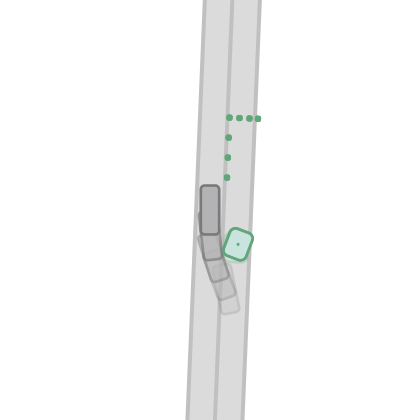

In [27]:
records = [json.loads(x) for x in records_1]
init_pos = np.array(records[-1]["ego_pos"])
init_rot = records[-1]["ego_rot"]

canvas.elements.append(svg.Rect(x=0, y=0,
                width=w, height=h,
                fill="white"))

viz = svg.G(elements=[], transform=[svg.Translate((w-1280)/2 - 10*OFFSET_Y, (h-1280)/2 + 10*OFFSET_X)])

viz.elements.append(get_roads(*init_pos, -np.rad2deg(init_rot), town))

for i, record in enumerate(records):
    global_translation = record["ego_pos"] - init_pos
    translation = rotate_point(global_translation, -init_rot)
    rot = record["ego_rot"] - init_rot

    g = svg.G(id=f"frame", class_="frame", elements=[], transform=[svg.Translate(translation[1]*10, -translation[0]*10), svg.Rotate(np.rad2deg(rot), 640, 640)])        

    g.elements += [box2svg(box, nospeed=False) for box in record["boxes"]]
    g.elements += [box2svg(ego_box, color=("#b3b3b5", "#7a7a7a"), nospeed=True)]

    g.opacity = max(0, 0.7**(len(records) - (i+1)))

    viz.elements.append(g)

canvas.elements.append(viz)

show(canvas)


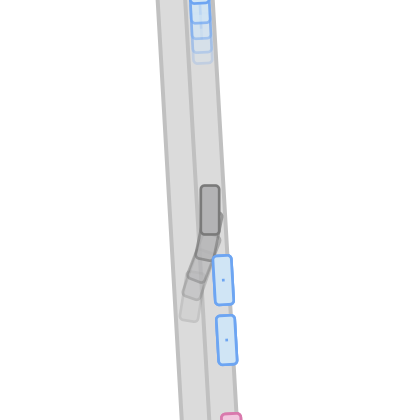

In [28]:
records = [json.loads(x) for x in records_2]
init_pos = np.array(records[-1]["ego_pos"])
init_rot = records[-1]["ego_rot"]

canvas.elements.append(svg.Rect(x=0, y=0,
                width=w, height=h,
                fill="white"))

viz = svg.G(elements=[], transform=[svg.Translate((w-1280)/2 - 10*OFFSET_Y, (h-1280)/2 + 10*OFFSET_X)])

viz.elements.append(get_roads(*init_pos, -np.rad2deg(init_rot), town))

for i, record in enumerate(records):
    global_translation = record["ego_pos"] - init_pos
    translation = rotate_point(global_translation, -init_rot)
    rot = record["ego_rot"] - init_rot

    g = svg.G(id=f"frame", class_="frame", elements=[], transform=[svg.Translate(translation[1]*10, -translation[0]*10), svg.Rotate(np.rad2deg(rot), 640, 640)])        

    g.elements += [box2svg(box, nospeed=False) for box in record["boxes"]]
    g.elements += [box2svg(ego_box, color=("#b3b3b5", "#7a7a7a"), nospeed=True)]

    g.opacity = max(0, 0.7**(len(records) - (i+1)))

    viz.elements.append(g)

canvas.elements.append(viz)

show(canvas)


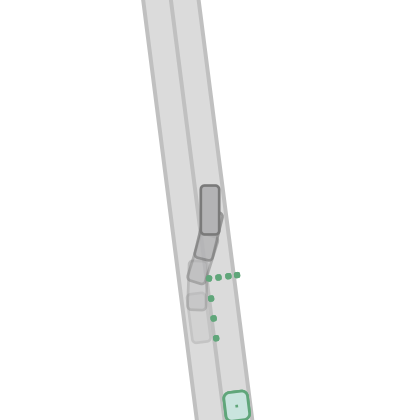

In [29]:
records = [json.loads(x) for x in records_3]
init_pos = np.array(records[-1]["ego_pos"])
init_rot = records[-1]["ego_rot"]

canvas.elements.append(svg.Rect(x=0, y=0,
                width=w, height=h,
                fill="white"))

viz = svg.G(elements=[], transform=[svg.Translate((w-1280)/2 - 10*OFFSET_Y, (h-1280)/2 + 10*OFFSET_X)])

viz.elements.append(get_roads(*init_pos, -np.rad2deg(init_rot), town))

for i, record in enumerate(records):
    global_translation = record["ego_pos"] - init_pos
    translation = rotate_point(global_translation, -init_rot)
    rot = record["ego_rot"] - init_rot

    g = svg.G(id=f"frame", class_="frame", elements=[], transform=[svg.Translate(translation[1]*10, -translation[0]*10), svg.Rotate(np.rad2deg(rot), 640, 640)])        

    g.elements += [box2svg(box, nospeed=False) for box in record["boxes"]]
    g.elements += [box2svg(ego_box, color=("#b3b3b5", "#7a7a7a"), nospeed=True)]

    g.opacity = max(0, 0.7**(len(records) - (i+1)))

    viz.elements.append(g)

canvas.elements.append(viz)

show(canvas)

In [30]:
# How to find failed routes in terms of index?!

In [31]:
# ds = PlanTDataset(f"/home/simon/PlanT_2_cleanup/PlanT_2_dataset/data", cfg)

In [32]:
# /home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/NonSignalizedJunctionLeftTurn/Town13_Rep0_1410_1_route0_07_25_02_47_37/bev_no_car_semantics/0540.png

In [33]:
# /home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/NonSignalizedJunctionLeftTurn/Town12_Rep0_3388_0_route0_07_25_04_21_50/bev_no_car_semantics/0373.png

In [34]:
# /home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/SignalizedJunctionRightTurn/Town13_Rep0_1696_0_route0_07_25_10_37_27/bev_no_car_semantics/0224.png

In [35]:
# /home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/MergerIntoSlowTrafficV2/Town12_Rep0_968_2_route0_07_25_01_19_48/bev_no_car_semantics/0262.png

In [36]:
# /home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/MergerIntoSlowTrafficV2/Town12_Rep0_968_35_route0_07_25_08_53_23/bev_no_car_semantics/0285.png

In [37]:
# /home/simon/PlanT_2_cleanup/PlanT_2_dataset/data/VehicleTurningRoutePedestrian/Town12_Rep0_1645_1_route0_07_25_00_39_26/bev_no_car_semantics/0111.png